# Likelihood Analysis of the Crab with fermipy

Instructions on installing fermipy and the Fermi ScienceTools : [fermipy Installation Instructions](http://fermipy.readthedocs.org/en/latest/install.html). 

Documentation for fermipy : [fermipy](http://fermipy.readthedocs.org)

Credit : notebook adapted from [Likelihood Analysis of a bright point source with fermipy](https://nbviewer.org/github/me-manu/fermipy-extra/blob/master/notebooks/pg1553.ipynb)

## Get the Data

The data were extracted from the [LAT data server](http://fermi.gsfc.nasa.gov/cgi-bin/ssc/LAT/LATDataQuery.cgi) with the following selections :

### Make a file list

First you need to make a file containing the list of all your input event files.

Read one file as a table

## Make a config file


Make a config file named 'config.yaml' ([yaml](http://yaml.org) format). For more details on the config file see [config.html](http://fermipy.readthedocs.org/en/latest/config.html). 

For Pass 8, each event class and event type combination has a dedicated IRF and isotropic model. Only a subset are shown here [LAT Background Models](https://fermi.gsfc.nasa.gov/ssc/data/access/lat/BackgroundModels.html)

In [1]:
cat new_data/config_5_6.yaml

data:
  evfile : ./new_data/photon_files.txt # list of photon files
  scfile : ./new_data/L220104003237B21939CE17_SC00.fits # spacecraft file

binning:
  roiwidth   : 5.0
  binsz      : 0.01
  binsperdec : 6

selection :
  emin : 100 # minimum energy
  emax : 300000 # maximum energy
  zmax    : 90 # zenith angle cut
  evclass : 128 # event class : simple point source analysis for pass 8
  evtype  : 3 # event type (front 1 + back events 2 = 3)
  tmin : 239557417  # starting time
  tmax : 662946879  # ending time
  filter : DATA_QUAL>0 && LAT_CONFIG==1 # Recommendation for Galactic Point Source Analysis 
  ra : 83.633
  dec : 22.0145

gtlike:
  edisp : True # Enable energy dispersion
  irfs : 'P8R2_SOURCE_V6'
  edisp_disable : ['isodiff','galdiff'] # Never enable energy dispersion for the isodiff or galdiff models

model:
  src_roiwidth : 5.0 # Includes sources outside of the ROI
  galdiff  : 'gll_iem_v07.fits' # The most recent and up to date model of the galactic diffuse emission
  iso

## Start the analysis

Next, you create an analysis script and run the setup steps (which include running the selections and generating exposure maps for example). This will take some time to run.

Fermipy will load the point source model, create an xml file for you which contains the models for all your sources in the region of interest (ROI).  All of this is configurable from python or from the config file. 

### Load up some useful modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from astropy.table import Table

Let's ignore some deprecation warnings

In [2]:
import warnings
from matplotlib import MatplotlibDeprecationWarning
warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning) 

### Import the GTAnalysis module from fermipy

You start by importing the module and then creating an instance of the analysis object from our config file.  When instantiating the analysis object we can override any options defined in the configuration file by passing keyword arguments to the object constructor.  
The verbosity parameter is set to 3 (INFO) which supresses DEBUG output. 

In [3]:
from fermipy.gtanalysis import GTAnalysis
gta = GTAnalysis('new_data/config_5_6.yaml',logging={'verbosity': 3},fileio={'outdir': 'Crab_5_bin_6'})
matplotlib.interactive(True)

2023-03-25 01:52:24 INFO    GTAnalysis.__init__(): 
--------------------------------------------------------------------------------
fermipy version v1.2 
ScienceTools version 2.2.0


### The setup routine

This gets everything ready for the likelihood analysis.  Note that fermipy will skip generating any files that already exist in the working directory.

In [4]:
gta.setup()

2023-03-25 01:52:24 INFO    GTAnalysis.setup(): Running setup.
2023-03-25 01:52:24 INFO    GTBinnedAnalysis.setup(): Running setup for component 00
2023-03-25 01:52:24 INFO    GTBinnedAnalysis._select_data(): Skipping data selection.
2023-03-25 01:52:24 INFO    GTBinnedAnalysis._create_ltcube(): Skipping LT Cube.
2023-03-25 01:52:25 INFO    GTBinnedAnalysis._create_expcube(): Skipping gtexpcube.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 54682.655283 from DATE-OBS.
Set MJD-END to 59582.996216 from DATE-END'. [astropy.wcs.wcs]
2023-03-25 01:52:25 INFO    GTBinnedAnalysis._create_srcmaps(): Skipping gtsrcmaps.
2023-03-25 01:52:25 INFO    GTBinnedAnalysis.setup(): Finished setup for component 00
2023-03-25 01:52:25 INFO    GTBinnedAnalysis._create_binned_analysis(): Creating BinnedAnalysis for component 00.
2023-03-25 01:52:44 INFO    GTAnalysis.setup(): Initializing source properties
2023-03-25 01:52:48 INFO    GTAnalysis.setup(): Finished setup.


Let's have a look at the components of the model :

In [5]:
 gta.print_model()

2023-03-25 01:52:48 INFO    GTAnalysis.print_model(): 
sourcename            offset    norm  eflux     index        ts       npred free
--------------------------------------------------------------------------------
4FGL J0534.5+2200      0.003   1.618  0.000898   2.71       nan    454357.0     
4FGL J0534.5+2201s     0.005   2.308  8.88e-05   3.86       nan     65963.5     
4FGL J0534.5+2201i     0.006   0.550  0.000319   1.57       nan     32705.0     
4FGL J0526.3+2246      2.037   1.375  2.13e-06   2.08       nan       549.5     
4FGL J0544.4+2238      2.375   1.565  3.84e-06   2.57       nan      1480.4     
isodiff                  ---   1.000    0.0506   2.24       nan     20185.9     
galdiff                  ---   1.000     0.266   0.00       nan    196486.2     



In [6]:
from astropy.io import fits
fits.open('Crab_5_bin_6/srcmap_00.fits').info()

Filename: Crab_5_bin_6/srcmap_00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      59   (500, 500, 21)   float32   
  1  GTI           1 BinTableHDU     33   74765R x 2C   [D, D]   
  2  EBOUNDS       1 BinTableHDU     38   21R x 3C   [I, 1E, 1E]   
  3  4FGL J0526.3+2246    1 ImageHDU        11   (500, 500, 22)   float32   
  4  4FGL J0534.5+2200    1 ImageHDU        11   (500, 500, 22)   float32   
  5  4FGL J0534.5+2201i    1 ImageHDU        11   (500, 500, 22)   float32   
  6  4FGL J0534.5+2201s    1 ImageHDU        11   (500, 500, 22)   float32   
  7  4FGL J0544.4+2238    1 ImageHDU        11   (500, 500, 22)   float32   
  8  galdiff       1 ImageHDU        11   (500, 500, 22)   float32   
  9  isodiff       1 ImageHDU        11   (500, 500, 22)   float32   


Before proceeding with the analysis let's have a quick look at the files that are produced by the setup function.

In [7]:
ls Crab_5_bin_6/*fits

Crab_5_bin_6/4fgl_j0526.3+2246_sed.fits   Crab_5_bin_6/fit0_all_freeing.fits
Crab_5_bin_6/4fgl_j0534.5+2200_sed.fits   Crab_5_bin_6/fit0.fits
Crab_5_bin_6/4fgl_j0534.5+2201i_sed.fits  Crab_5_bin_6/ft1_00.fits
Crab_5_bin_6/4fgl_j0534.5+2201s_sed.fits  Crab_5_bin_6/ltcube_00.fits
Crab_5_bin_6/4fgl_j0544.4+2238_sed.fits   Crab_5_bin_6/mcube_fit0_00.fits
Crab_5_bin_6/bexpmap_00.fits              Crab_5_bin_6/mcube_fit0.fits
Crab_5_bin_6/bexpmap_roi_00.fits          Crab_5_bin_6/sed2246.fits
Crab_5_bin_6/ccube_00.fits                Crab_5_bin_6/srcmap_00.fits
Crab_5_bin_6/ccube.fits


Here is a brief explanation of the contents of each file and its role in the analysis:

* **ft1_00.fits**: Event list.  This is generated by running gtselect and gtmktime on our input file list.
* **bexpmap_00.fits**: All-sky binned exposure map.  This map is interpolated to create an exposure model when generating the srcmap file.
* **bexpmap_roi_00.fits**: Binned exposure map for the ROI.  This file is only provided for visualization purposes in order to have an exposure map with the same binning as the data and model maps.
* **ccube_00.fits**: Counts cube for the ROI.
* **ltcube_00.fits**: Livetime cube.  This contains a map of the livetime for this observation over the whole sky as a function of incidence angle.
* **srcmap_00.fits**: Source map cube.  This file contains maps for each of the components in the ROI after convolution with exposure and the PSF.  Note that energy dispersion is applied at run-time.

Note that all of the files have a numerical suffix '00'.  This is the analysis component index.  In a multi-component analysis there would be instances of all of the above files for each analysis component.  The files with no component index are co-added maps that are provided for visualization purposes.

To see example of one of these files we can open and plot the counts cube file.  This is a 3D cube that contains the distribution of events as a function of energy and two spatial coordinates.  In the example below we sum over the energy dimension of the cube to make a 2-D sky image.

Filename: Crab_5_bin_6/ccube_00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     137   (500, 500, 21)   int32   
  1  EBOUNDS       1 BinTableHDU     43   21R x 3C   [I, 1E, 1E]   
  2  GTI           1 BinTableHDU     50   74765R x 2C   [D, D]   


Set MJD-END to 59582.996227 from DATE-END'. [astropy.wcs.wcs]


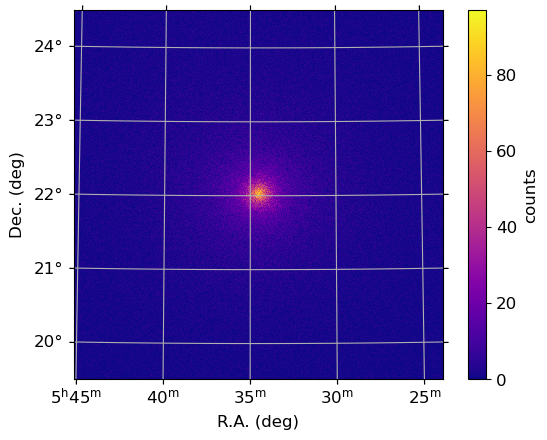

In [8]:
from astropy.io import fits
from astropy.wcs import WCS

h = fits.open('Crab_5_bin_6/ccube_00.fits')
h.info()

wcs = WCS(h[0].header).dropaxis(-1)  # load the coordinate system, drop the energy axis

counts = h[0].data

plt.subplot(projection=wcs)
im = plt.imshow(np.sum(counts,axis=0),interpolation='nearest',origin='lower', cmap='plasma')
plt.colorbar(im, label="counts")
plt.grid()
plt.gca().tick_params(direction='out')
plt.gca().set_xlabel("R.A. (deg)")
plt.gca().set_ylabel("Dec. (deg)")
plt.savefig("Crab_5_bin_6/ccube_00.png")

In [9]:
h[0].header

SIMPLE  =                    T / File conforms to NOST standard                 
BITPIX  =                   32 / Bits per pixel                                 
NAXIS   =                    3 / No data is associated with this header         
NAXIS1  =                  500 / Length of data axis 1                          
NAXIS2  =                  500 / Length of data axis 2                          
NAXIS3  =                   21 / Length of data axis 3                          
EXTEND  =                    T / Extensions may be present                      
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
CTYPE1  = 'RA---AIT'           / RA---%%%, %%% represents the projection method 
CRPIX1  =                250.5 / Reference pixel                                
CRVAL1  =               83.633 / RA at the reference pixel                      
CDELT1  =                -0.

In [46]:
catalog = fits.open('gll_psc_v22.fit')
c = Table(catalog[1].data)

In [47]:
c

<Table length=5065>
   Source_Name     RAJ2000  DEJ2000     GLON       GLAT     ... ASSOC_PROB_LR   RA_Counterpart    DEC_Counterpart  Unc_Counterpart Flags
      str18        float32  float32   float32    float32    ...    float32         float64            float64          float32     int16
------------------ -------- -------- --------- ------------ ... ------------- ------------------ ----------------- --------------- -----
4FGL J0000.3-7355    0.0983  -73.922 307.70898   -42.729538 ...           0.0                nan               nan             nan     0
4FGL J0001.2+4741    0.3126  47.6859  114.2502   -14.338059 ...    0.93856317          0.3293408     47.7002009361         8.4e-07     0
4FGL J0001.2-0747    0.3151  -7.7971  89.03272    -67.30501 ...    0.93293214          0.3251038      -7.774144975         1.8e-07     0
4FGL J0001.5+2113    0.3815  21.2183 107.64935   -40.167652 ...    0.95818156          0.3848771     21.2267429583         3.4e-07     0
4FGL J0001.6-4156    0.4165 -41.9425 334.22635    -72.02855 ...    0.85456926     0.386479595833    -41.9237053972         6.9e-05     0
4FGL J0002.1-6728    0.5378 -67.4746 310.08493   -48.963467 ...     0.9044934     0.563303229167    -67.4481760667         1.6e-05     0
4FGL J0002.1+6721    0.5419  67.3578 118.20349     4.939485 ...    0.95309293 0.5391738414764404 67.41764068603516         0.00045     1
4FGL J0002.8+6217    0.7201  62.2905 117.32041 -0.051036116 ...           0.0 0.7421860098838806 62.26932907104492   3.1734315e-05     0
4FGL J0003.1-5248    0.7817 -52.8071  318.9899   -62.788944 ...    0.85980093     0.831668583333    -52.7909124778    4.628482e-06     0
               ...      ...      ...       ...          ... ...           ...                ...               ...             ...   ...
4FGL J2358.1-2853  359.5498 -28.8936 21.289448    -78.12421 ...     0.9362704      359.570714825    -28.8928064306         2.4e-07     0
4FGL J2358.3-1021  359.5822 -10.3616  83.67932      -69.081 ...     0.9992676      359.545343346    -10.3357253889         6.8e-08     0
4FGL J2358.3+3830  359.5883  38.5097 111.66197   -23.197569 ...           0.0      359.604886054     38.4823602167         1.9e-07     0
4FGL J2358.5-1808  359.6387 -18.1408  66.59328    -74.86357 ...           0.0      359.653507225    -18.1215255611         5.5e-07     0
4FGL J2359.0+3922  359.7548  39.3669  112.0038   -22.389944 ...     0.9671962      359.749396517     39.3745294278         1.2e-07     0
4FGL J2359.0-3038  359.7719 -30.6367 12.809109    -78.02417 ...      0.995549      359.782931004    -30.6279650528         1.1e-06     0
4FGL J2359.1+1719  359.7756  17.3225 105.51741   -43.772465 ...           0.0       359.75488035     17.3237807889         7.1e-07     0
4FGL J2359.3-2049  359.8357 -20.8189 58.090145    -76.54286 ...    0.97152853      359.831390913    -20.7988971833           1e-06     0
4FGL J2359.3+1444   359.839  14.7498 104.56471   -46.256252 ...           0.0 359.82501220703125 14.81470012664795          0.0045     0
4FGL J2359.9-3736  359.9816  -37.616 345.66284   -74.919624 ...           0.0       0.0350590375    -37.6390759444   3.2783254e-07     0

In [48]:
catalog = fits.open("gll_psc_v22.fit")
t = Table(catalog[1].data)
new_glon = np.logical_and(t['RAJ2000'] >=83.633-2.5, t['RAJ2000']<=83.633+2.5)
new_tg = t[new_glon]
new_glat = np.logical_and(new_tg['DEJ2000'] >= 22.0145-2.5, new_tg['DEJ2000'] <=22.0145+2.5)
sources = new_tg[new_glat]

In [49]:
sources

<Table length=5>
   Source_Name     RAJ2000 DEJ2000    GLON      GLAT    Conf_68_SemiMajor ... ASSOC_PROB_LR   RA_Counterpart   DEC_Counterpart   Unc_Counterpart Flags
      str18        float32 float32  float32   float32        float32      ...    float32         float64           float64           float32     int16
------------------ ------- ------- --------- ---------- ----------------- ... ------------- ----------------- ------------------ --------------- -----
4FGL J0526.3+2246  81.5908 22.7778 182.88174  -6.956808       0.029417891 ...           0.0     81.5918081625      22.8005882111         5.7e-07     0
4FGL J0534.5+2201i  83.633   22.02 184.55273  -5.781481               nan ...           nan 83.62899780273438 22.020000457763672            0.06  2048
4FGL J0534.5+2201s 83.6331 22.0199 184.55287  -5.781456               nan ...     0.9998551 83.62999725341797 22.020000457763672         0.00045    20
4FGL J0534.5+2200  83.6367 22.0149 184.55891 -5.7813134      0.0045021093 ...    0.99996907 83.62999725341797 22.020000457763672    3.681828e-05     0
4FGL J0544.4+2238  86.1093 22.6418  185.2363 -3.5079103        0.07696757 ...           0.0               nan                nan             nan     0

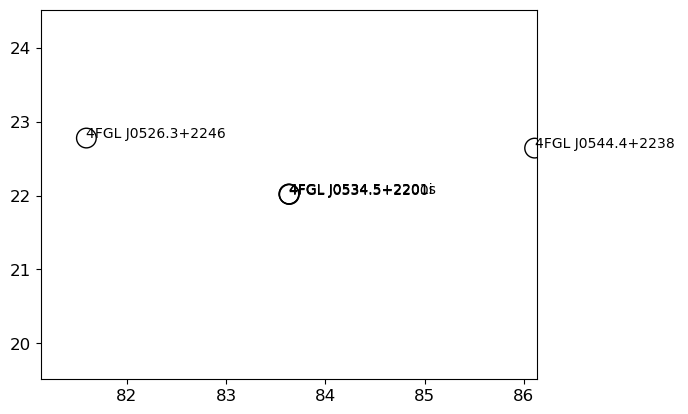

In [14]:
plt.scatter(new_t['RAJ2000'], new_t['DEJ2000'],edgecolor = 'black' , s=200 , facecolor='none')
for i, txt in enumerate(new_t['Source_Name']):           
    plt.annotate(txt, (new_t['RAJ2000'][i], new_t['DEJ2000'][i]),fontsize=10,color='black')
plt.ylim(22.0145-2.5,22.0145+2.5)
plt.xlim(83.633-2.5,83.633+2.5)
plt.show()

In [91]:
from astropy.io import fits
from astropy.wcs import WCS

h = fits.open('Crab_5_bin_6/ccube_00.fits')
#h.info()

wcs = WCS(h[0].header).dropaxis(-1)  # load the coordinate system, drop the energy axis

counts = h[0].data

plt.subplot(projection=wcs)
plt.scatter(new_t['RAJ2000'], new_t['DEJ2000'],edgecolor = 'black' , s=200 , facecolor='none')
for i, txt in enumerate(new_t['Source_Name']):           
    plt.annotate(txt, (new_t['RAJ2000'][i], new_t['DEJ2000'][i]),fontsize=10,color='black')

im = plt.imshow(np.sum(counts,axis=0),interpolation='nearest',origin='lower', cmap='plasma')
plt.colorbar(im, label="counts")
#plt.ylim(22.0145-2.5,22.0145+2.5)
#plt.xlim(83.633-2.5,83.633+2.5)
plt.grid()
plt.gca().tick_params(direction='out')
plt.gca().set_xlabel("R.A. (deg)")
plt.gca().set_ylabel("Dec. (deg)")

#plt.savefig("Crab_5_bin_6/ccube_00.png")

Set MJD-END to 59582.996227 from DATE-END'. [astropy.wcs.wcs]


In [16]:
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---AIT'  'DEC--AIT'  
CRVAL : 83.633  22.0145  
CRPIX : 250.5  250.5  
NAXIS : 500  500

<function matplotlib.pyplot.show(close=None, block=None)>

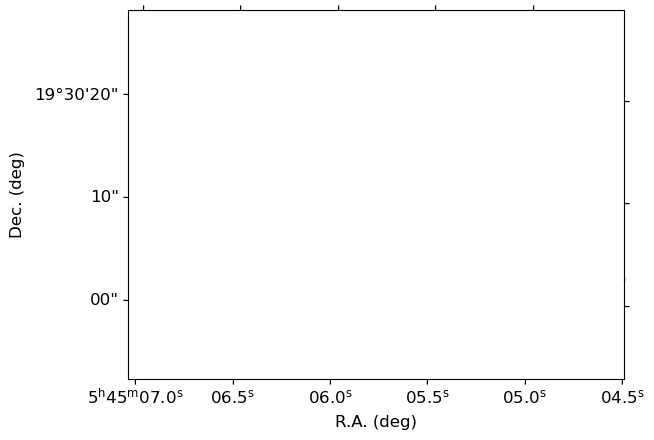

In [17]:
plt.subplot(projection=wcs)
plt.gca().set_xlabel("R.A. (deg)")
plt.gca().set_ylabel("Dec. (deg)")
plt.show

In [18]:
e = fits.open('Crab_5_bin_6/ft1_00.fits')

In [19]:
e[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
CHECKSUM= 'IgfbIZZaIffaIZZa'   / HDU checksum updated 2022-02-15T04:42:45       
TELESCOP= 'GLAST   '           / name of telescope generating data              
INSTRUME= 'LAT     '           / name of instrument generating data             
EQUINOX =                2000. / equinox for ra and dec                         
RADECSYS= 'FK5     '           / world coord. system for this file (FK5 or FK4) 
DATE    = '2022-02-15T04:20:30.9999' / file creation date (YYYY-MM-DDThh:mm:ss U
DATE-OBS= '2008-08-04T15:43:

In [20]:
e[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   98 / width of table in bytes                        
NAXIS2  =              1104079 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                   23 / number of fields in each row                   
TTYPE1  = 'ENERGY  '           / energy of event                                
TFORM1  = 'E       '           / data format of field: 4-byte REAL              
TTYPE2  = 'RA      '           / right ascension (J2000) of event               
TFORM2  = 'E       '           / data format of field: 4-byte REAL              
TTYPE3  = 'DEC     '        

In [21]:
e.info()

Filename: Crab_5_bin_6/ft1_00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      31   ()      
  1  EVENTS        1 BinTableHDU    227   1104079R x 23C   [E, E, E, E, E, E, E, E, E, D, J, J, I, 3I, 32X, 32X, I, D, E, E, E, E, E]   
  2  GTI           1 BinTableHDU     46   74765R x 2C   [D, D]   


In [22]:
e[1].

SyntaxError: invalid syntax (3177986291.py, line 1)

In [ ]:
te = Table(e[1].data)

In [ ]:
te

In [ ]:
np.max(te['RA'])

In [38]:
87.98524-83.633

4.352240000000009

In [18]:
np.min(te['RA'])

79.28039

In [39]:
83.633-79.28039

4.3526099999999985

In [32]:
87.98524-79.28039

8.704850000000008

In [35]:
np.max(te['DEC'])

26.049635

In [36]:
np.min(te['DEC'])

17.981752

In [37]:
26.049635-17.981752

8.067882999999998

In [78]:
from astropy.io import fits
from astropy.wcs import WCS

h = fits.open('Crab_5_bin_6/ft1_00.fits')
h.info()

wcs = WCS(h[1].header).dropaxis(-1)  # load the coordinate system, drop the energy axis

#counts = h[1].data

plt.subplot(projection=wcs)
#im = plt.imshow(np.sum(counts,axis=0),interpolation='nearest',origin='lower', cmap='plasma',vmax=90)
#plt.colorbar(im, label="counts")
#plt.grid()
#plt.gca().tick_params(direction='out')
#plt.gca().set_xlabel("R.A. (deg)")
#plt.gca().set_ylabel("Dec. (deg)")
#plt.savefig("Crab_5_bin_6/ccube_00.png")

Filename: Crab_5_bin_6/ft1_00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      31   ()      
  1  EVENTS        1 BinTableHDU    227   1104079R x 23C   [E, E, E, E, E, E, E, E, E, D, J, J, I, 3I, 32X, 32X, I, D, E, E, E, E, E]   
  2  GTI           1 BinTableHDU     46   74765R x 2C   [D, D]   


IndexError: list index out of range

<Figure size 432x288 with 0 Axes>

In [76]:
h[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   98 / width of table in bytes                        
NAXIS2  =              1104079 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                   23 / number of fields in each row                   
TTYPE1  = 'ENERGY  '           / energy of event                                
TFORM1  = 'E       '           / data format of field: 4-byte REAL              
TTYPE2  = 'RA      '           / right ascension (J2000) of event               
TFORM2  = 'E       '           / data format of field: 4-byte REAL              
TTYPE3  = 'DEC     '        

In [73]:
Table(h[1].data)

<Table length=1104079>
  ENERGY      RA       DEC        L         B        THETA   ... DIFRSP0 DIFRSP1 DIFRSP2 DIFRSP3 DIFRSP4
 float32   float32   float32   float32   float32    float32  ... float32 float32 float32 float32 float32
--------- --------- --------- --------- ---------- --------- ... ------- ------- ------- ------- -------
184.90147  86.73904 19.482662 188.25197 -4.6390367 33.689953 ...     0.0     0.0     0.0     0.0     0.0
233.29193  86.88562 19.697296  188.1384 -4.4102974 50.489273 ...     0.0     0.0     0.0     0.0     0.0
255.41899  86.51337  19.40808 188.20625 -4.8598824  51.67763 ...     0.0     0.0     0.0     0.0     0.0
 341.9336 87.347855 20.145056 187.97606    -3.8077 39.876644 ...     0.0     0.0     0.0     0.0     0.0
139.22578  86.25833 19.125177 188.32494   -5.21204 40.908405 ...     0.0     0.0     0.0     0.0     0.0
108.21607  86.07035 18.928612 188.40175  -5.465753  61.10407 ...     0.0     0.0     0.0     0.0     0.0
141.31065 86.356316 18.892399 188.57318  -5.252756 63.169758 ...     0.0     0.0     0.0     0.0     0.0
640.21045 87.372894   20.1902 187.94922 -3.7644224 47.940655 ...     0.0     0.0     0.0     0.0     0.0
104.72193  86.81077 19.627075 188.16252 -4.5068464 23.660807 ...     0.0     0.0     0.0     0.0     0.0
      ...       ...       ...       ...        ...       ... ...     ...     ...     ...     ...     ...
 4479.353  84.54446  21.81538 185.17897 -5.1746173 74.075554 ...     0.0     0.0     0.0     0.0     0.0
1669.8353  85.58659 22.803316 184.84596 -3.8347235 78.449196 ...     0.0     0.0     0.0     0.0     0.0
108.61472 81.531296  23.48585   182.256 -6.6129565 73.775795 ...     0.0     0.0     0.0     0.0     0.0
 1326.489 80.317856 21.441854 183.34798 -8.6778965  71.27658 ...     0.0     0.0     0.0     0.0     0.0
 409.2265  83.70665 18.694294 187.42325 -7.4949646  74.02123 ...     0.0     0.0     0.0     0.0     0.0
369.36023  82.08271 21.038715 184.60126 -7.5251083  75.13452 ...     0.0     0.0     0.0     0.0     0.0
 274.4706  84.04955 20.041037  186.4455 -6.5067363  74.89667 ...     0.0     0.0     0.0     0.0     0.0
 282.7161 82.930405 23.116976 183.27255  -5.737827 74.690025 ...     0.0     0.0     0.0     0.0     0.0
1104.0181  81.00068  20.26765 184.69489  -8.794387  75.65324 ...     0.0     0.0     0.0     0.0     0.0
 429.5664  84.14371  18.82854 187.52905 -7.0727477  74.83356 ...     0.0     0.0     0.0     0.0     0.0

In [74]:
h[1].data

FITS_rec([( 184.90147, 86.73904 , 19.482662, 188.25197, -4.6390367, 33.689953,  44.95822 ,  4.2977786, 124.182335, 2.39562938e+08, 8048259, 239559565, 0, [0, 0, 0], [  0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   1,   1,   0,   0,   0,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1], [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   1,   0,   0,   1,   0], 1,  12.07363898, 0., 0., 0., 0., 0.),
          ( 233.29193, 86.88562 , 19.697296, 188.1384 , -4.4102974, 50.489273, 315.67563 , 38.83088  ,  89.86262 , 2.39614008e+08, 3579382, 239612600, 0, [0, 0, 0], [  0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   1,   1,   0,   0,   0,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1], [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   1,   0,   0, 

In [70]:
f

Next, we look at the sky map of the exposure

... and the energy dependence of the exposure for the central pixel

We can now inspect the state of the ROI before the fit

In [5]:
gta.print_roi()

2022-05-03 15:02:24 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
4FGL J0534.5+2200   PointSource    PLSuperExpCuto    0.003       nan    454357.0
4FGL J0534.5+2201s  PointSource    PowerLaw          0.005       nan     65963.5
4FGL J0534.5+2201i  RadialGaussian LogParabola       0.006       nan     32705.0
4FGL J0526.3+2246   PointSource    PowerLaw          2.037       nan       549.5
4FGL J0544.4+2238   PointSource    PowerLaw          2.375       nan      1480.4
isodiff             ConstantValue  FileFunction      -----       nan     20185.9
galdiff             MapCubeFunctio PowerLaw          -----       nan    196486.2



Additional details about an individual source can be retrieved by printing the corresponding source object

In [11]:
print(gta.roi['4FGL J0534.5+2201i'])

Name           : 4FGL J0534.5+2201i
Associations   : ['4FGL J0534.5+2201i', 'Crab Nebula', 'J0534+2205', 'Crab']
RA/DEC         :     83.633/    22.020
GLON/GLAT      :    184.553/    -5.781
TS             : nan
Npred          : 32705.03
Flux           :  9.72e-08 +/-      nan
EnergyFlux     : 0.0003193 +/-      nan
SpatialModel   : RadialGaussian
SpectrumType   : LogParabola
Spectral Parameters
b'norm'        :    5.5e-13 +/-        nan
b'alpha'       :       1.75 +/-        nan
b'beta'        :       0.08 +/-        nan
b'Eb'          :      1e+04 +/-        nan


In [6]:
print(gta.roi['4FGL J0534.5+2200'])

Name           : 4FGL J0534.5+2200
Associations   : ['4FGL J0534.5+2200', 'PSR J0534+2200', 'Crab IC field', 'J0534+2205', 'Crab pulsar']
RA/DEC         :     83.637/    22.015
GLON/GLAT      :    184.559/    -5.781
TS             : 646123.30
Npred          : 440754.99
Flux           : 2.205e-06 +/- 5.27e-09
EnergyFlux     : 0.0008656 +/- 2.41e-06
SpatialModel   : PointSource
SpectrumType   : PLSuperExpCutoff2
Spectral Parameters
b'Prefactor'   :  1.616e-10 +/-  1.643e-12
b'Index1'      :     -1.876 +/-   0.004468
b'Scale'       :       1463 +/-        nan
b'Expfactor'   :   0.004599 +/-  7.079e-05
b'Index2'      :     0.6667 +/-        nan


In [7]:
print(gta.roi['4FGL J0534.5+2201s'])

Name           : 4FGL J0534.5+2201s
Associations   : ['4FGL J0534.5+2201s', 'Crab Nebula', 'J0534+2205', 'Crab']
RA/DEC         :     83.633/    22.020
GLON/GLAT      :    184.553/    -5.781
TS             : 13412.28
Npred          : 65861.02
Flux           : 5.756e-07 +/- 5.61e-09
EnergyFlux     : 8.896e-05 +/- 1.13e-06
SpatialModel   : PointSource
SpectrumType   : PowerLaw
Spectral Parameters
b'Prefactor'   :   2.19e-07 +/-  6.381e-09
b'Index'       :      -3.82 +/-     0.0294
b'Scale'       :      50.55 +/-        nan


## Do the likelihood fitting

Now that all of the ancillary files have been generated, we can move on to the actual fitting.  The first thing you should do is free some of the sources since all of the sources are initially fixed.  We'll just free those sources in the center region.

In [76]:
gta.print_params()

2023-03-25 02:57:40 INFO    GTAnalysis.print_params(): 
 idx parname                  value     error       min       max     scale free
--------------------------------------------------------------------------------



In [77]:
gta.optimize()

2023-03-25 02:57:42 INFO    GTAnalysis.optimize(): Starting


Joint fit  ['4FGL J0534.5+2200', 'galdiff', '4FGL J0534.5+2201s', '4FGL J0534.5+2201i']
Drm_Cache::update Measured counts < 0 4FGL J0534.5+2200 20 -2.01932e-14 7.55111e-15
5.67582e-06 7.04657e-06 7.314e-06 6.71497e-06 5.64304e-06 4.36391e-06 3.16364e-06 2.12747e-06 1.30566e-06 7.35946e-07 3.84415e-07 1.87899e-07 8.28709e-08 3.16724e-08 1.0221e-08 2.73688e-09 5.46617e-10 7.55667e-11 6.64736e-12 3.26177e-13 7.55111e-15 
Fitting shape 4FGL J0534.5+2200 TS: 205249.537
Fitting shape galdiff TS: 103766.661
Fitting shape 4FGL J0534.5+2201i TS:  11930.046
Fitting shape 4FGL J0534.5+2201s TS:   8452.904
Fitting shape isodiff TS:   1048.092
Fitting shape 4FGL J0526.3+2246 TS:     60.221
Fitting shape 4FGL J0544.4+2238 TS:     28.531


2023-03-25 02:58:14 INFO    GTAnalysis.optimize(): Finished
2023-03-25 02:58:14 INFO    GTAnalysis.optimize(): LogLike: -1251249.035891 Delta-LogLike: 216.852621
2023-03-25 02:58:14 INFO    GTAnalysis.optimize(): Execution time: 32.74 s


{'loglike0': -1251465.8885117695,
 'loglike1': -1251249.0358906996,
 'dloglike': 216.85262106987648,
 'config': {'npred_threshold': 1.0,
  'npred_frac': 0.95,
  'shape_ts_threshold': 25.0,
  'max_free_sources': 5,
  'skip': [],
  'optimizer': {'optimizer': 'MINUIT',
   'tol': 0.001,
   'max_iter': 100,
   'init_lambda': 0.0001,
   'retries': 3,
   'min_fit_quality': 2,
   'verbosity': 0}}}

In [78]:
gta.print_params()

2023-03-25 02:58:14 INFO    GTAnalysis.print_params(): 
 idx parname                  value     error       min       max     scale free
--------------------------------------------------------------------------------



In [79]:
gta.free_sources(free=False) # make sure everything is fixed first

# Free Normalization of all Sources within 3 deg of ROI center
gta.free_sources(distance=3.0,pars='norm')

# Free normalizations of isotropic and galactic diffuse components
gta.free_source('galdiff', pars='norm')
gta.free_source('isodiff')

2023-03-25 02:58:14 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J0534.5+2200     : ['Prefactor']
2023-03-25 02:58:14 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J0534.5+2201s    : ['Prefactor']
2023-03-25 02:58:14 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J0534.5+2201i    : ['norm']
2023-03-25 02:58:14 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J0526.3+2246     : ['Prefactor']
2023-03-25 02:58:14 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J0544.4+2238     : ['Prefactor']
2023-03-25 02:58:14 INFO    GTAnalysis.free_source(): Freeing parameters for isodiff               : ['Normalization']
2023-03-25 02:58:14 INFO    GTAnalysis.free_source(): Freeing parameters for galdiff               : ['Prefactor']


In [80]:
gta.print_params()

2023-03-25 02:58:14 INFO    GTAnalysis.print_params(): 
 idx parname                  value     error       min       max     scale free
--------------------------------------------------------------------------------
4FGL J0526.3+2246
   0 Prefactor                 1.55         0     1e-05     1e+03     1e-14    *
   1 Index                     2.53         0         0         5        -1     
   2 Scale                  4.4e+03         0   4.4e+03   4.4e+03         1     
4FGL J0534.5+2200
   3 Prefactor                 1.62         0     1e-05     1e+03     1e-10    *
   4 Index1                    1.88         0         0         5        -1     
   5 Scale                 1.46e+03         0  1.46e+03  1.46e+03         1     
   6 Expfactor                 0.46         0      -0.5       0.5      0.01     
   7 Index2                   0.667         0         0         2         1     
4FGL J0534.5+2201i
   8 norm                     0.563         0     1e-05     1e+03     1e-12    

In [81]:
gta.free_sources(free=False) # make sure everything is fixed first

# Free Normalization of all Sources within 3 deg of ROI center
gta.free_sources(distance=3.0)

# Free normalizations of isotropic and galactic diffuse components
#gta.free_source('galdiff')
#gta.free_source('isodiff')

2023-03-25 02:58:14 INFO    GTAnalysis.free_source(): Fixing parameters for 4FGL J0534.5+2200     : ['Prefactor']
2023-03-25 02:58:14 INFO    GTAnalysis.free_source(): Fixing parameters for 4FGL J0534.5+2201s    : ['Prefactor']
2023-03-25 02:58:14 INFO    GTAnalysis.free_source(): Fixing parameters for 4FGL J0534.5+2201i    : ['norm']
2023-03-25 02:58:14 INFO    GTAnalysis.free_source(): Fixing parameters for 4FGL J0526.3+2246     : ['Prefactor']
2023-03-25 02:58:14 INFO    GTAnalysis.free_source(): Fixing parameters for 4FGL J0544.4+2238     : ['Prefactor']
2023-03-25 02:58:14 INFO    GTAnalysis.free_source(): Fixing parameters for isodiff               : ['Normalization']
2023-03-25 02:58:14 INFO    GTAnalysis.free_source(): Fixing parameters for galdiff               : ['Prefactor']
2023-03-25 02:58:14 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J0534.5+2200     : ['Prefactor', 'Index1', 'Expfactor']
2023-03-25 02:58:14 INFO    GTAnalysis.free_source(): Freeing par

In [82]:
gta.print_params()

2023-03-25 02:58:14 INFO    GTAnalysis.print_params(): 
 idx parname                  value     error       min       max     scale free
--------------------------------------------------------------------------------
4FGL J0526.3+2246
   0 Prefactor                 1.55         0     1e-05     1e+03     1e-14    *
   1 Index                     2.53         0         0         5        -1    *
   2 Scale                  4.4e+03         0   4.4e+03   4.4e+03         1     
4FGL J0534.5+2200
   3 Prefactor                 1.62         0     1e-05     1e+03     1e-10    *
   4 Index1                    1.88         0         0         5        -1    *
   5 Scale                 1.46e+03         0  1.46e+03  1.46e+03         1     
   6 Expfactor                 0.46         0      -0.5       0.5      0.01    *
   7 Index2                   0.667         0         0         2         1     
4FGL J0534.5+2201i
   8 norm                     0.563         0     1e-05     1e+03     1e-12    

In this simple anlaysis we are leaving the spectral shapes of sources fixed but we're going to free the spectral shape of the source we care about.  

In [83]:
gta.free_source('4FGL J0534.5+2201i')
gta.free_source('4FGL J0534.5+2200')
gta.free_source('4FGL J0534.5+2201s')
gta.free_source('4FGLJ0526.3+2246')
gta.free_source('4FGL J0544.4+2238')

Now, actually do the fit.  The software does its best to get the fit to converge by running the fit several times.

In [84]:
fit_results = gta.fit()

2023-03-25 02:58:14 INFO    GTAnalysis.fit(): Starting fit.
/home/user/anaconda3/envs/fermi/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
2023-03-25 02:59:04 INFO    GTAnalysis.fit(): Fit returned successfully. Quality:   2 Status: 102
2023-03-25 02:59:04 INFO    GTAnalysis.fit(): LogLike: -1251186.612 DeltaLogLike:       62.423 


The dictionary returned by the fit method returns a variety of diagnostic information about the fit including the fit quality, the relative improvement in the likelihood, and the correlations among the fit parameters. For example :

In [85]:
print('Fit Quality: ',fit_results['fit_quality'])
print(gta.roi['4FGL J0534.5+2201i'])

Fit Quality:  2
Name           : 4FGL J0534.5+2201i
Associations   : ['4FGL J0534.5+2201i', 'Crab Nebula', 'J0534+2205', 'Crab']
RA/DEC         :     83.633/    22.020
GLON/GLAT      :    184.553/    -5.781
TS             : 24969.27
Npred          : 152125.78
Flux           : 6.887e-07 +/-  1.5e-08
EnergyFlux     : 0.0005706 +/- 6.45e-06
SpatialModel   : RadialGaussian
SpectrumType   : LogParabola
Spectral Parameters
b'norm'        :  7.689e-13 +/-  8.136e-15
b'alpha'       :       2.04 +/-   0.004388
b'beta'        :    0.01832 +/-   0.001382
b'Eb'          :      1e+04 +/-        nan


Let's have a look at the sources and the best-fit parameters after the fit

In [86]:
gta.print_roi()

2023-03-25 02:59:04 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
4FGL J0534.5+2200   PointSource    PLSuperExpCuto    0.003  57395.87    338029.1
4FGL J0534.5+2201s  PointSource    PowerLaw          0.005   3977.31     39425.6
4FGL J0534.5+2201i  RadialGaussian LogParabola       0.006  24969.27    152125.8
4FGL J0526.3+2246   PointSource    PowerLaw          2.037    114.29      4237.3
4FGL J0544.4+2238   PointSource    PowerLaw          2.375     78.07      3823.2
isodiff             ConstantValue  FileFunction      -----    964.94     37206.2
galdiff             MapCubeFunctio PowerLaw          -----  74314.56    188262.7



In [87]:
gta.print_params()

2023-03-25 02:59:04 INFO    GTAnalysis.print_params(): 
 idx parname                  value     error       min       max     scale free
--------------------------------------------------------------------------------
4FGL J0526.3+2246
   0 Prefactor                 1.08     0.604     1e-05     1e+03     1e-14    *
   1 Index                     2.95     0.286         0         5        -1    *
   2 Scale                  4.4e+03         0   4.4e+03   4.4e+03         1     
4FGL J0534.5+2200
   3 Prefactor                 1.24   0.00862     1e-05     1e+03     1e-10    *
   4 Index1                     1.9   0.00394         0         5        -1    *
   5 Scale                 1.46e+03         0  1.46e+03  1.46e+03         1     
   6 Expfactor                  0.5  3.71e-05      -0.5       0.5      0.01    *
   7 Index2                   0.667         0         0         2         1     
4FGL J0534.5+2201i
   8 norm                     0.769   0.00814     1e-05     1e+03     1e-12    

You can then save the state of the roi to an output file for reference later.

In [90]:
#gta.write_roi('fit0',make_plots=True)
gta.write_roi('fit0_all_freeing',make_plots=True)
plt.show()

2023-03-25 03:01:27 INFO    GTBinnedAnalysis.write_xml(): Writing /home/user/fermi/Crab_nebula/Crab_nebula_Analysis/Crab_5_bin_6/fit0_all_freeing_00.xml...
2023-03-25 03:01:27 INFO    GTAnalysis.write_fits(): Writing /home/user/fermi/Crab_nebula/Crab_nebula_Analysis/Crab_5_bin_6/fit0_all_freeing.fits...
2023-03-25 03:01:38 INFO    GTAnalysis.write_roi(): Writing /home/user/fermi/Crab_nebula/Crab_nebula_Analysis/Crab_5_bin_6/fit0_all_freeing.npy...


AttributeError: 'LinearSegmentedColormap' object has no attribute 'copy'

We can also inspect the final model map. The next command will return the model map as a `gammapy.Map` instance (Full documentation for `gammapy`  [here](https://docs.gammapy.org)).

In [20]:
model_map = gta.write_model_map("fit0")

2022-03-03 13:55:33 INFO    GTBinnedAnalysis.write_model_map(): Generating model map for component 00.


In [21]:
print(model_map)

[WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (500, 500, 21)
	ndim  : 3
	unit  : 
	dtype : float32
, WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (500, 500, 21)
	ndim  : 3
	unit  : 
	dtype : float64
]


In [22]:
model_map[0].geom.axes[0]

MapAxis

	name       : energy    
	unit       : 'MeV'     
	nbins      : 21        
	node type  : edges     
	edges min  : 1.0e+02 MeV
	edges max  : 3.0e+05 MeV
	interp     : log       

Plot the model map summed over the energy axis. The plot shows the predicted number of counts for all model components. 

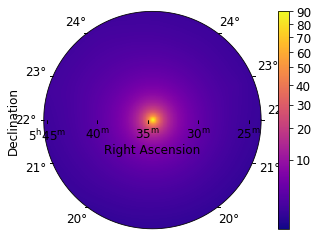

In [23]:
model_map[0].sum_over_axes(["energy"]).plot(stretch="sqrt",cmap='plasma', add_cbar=True)
plt.savefig("Crab_5_bin_6/model.png")

Plot each energy bin of the model map. This nicely illustrates the broad PSF at low energies. 

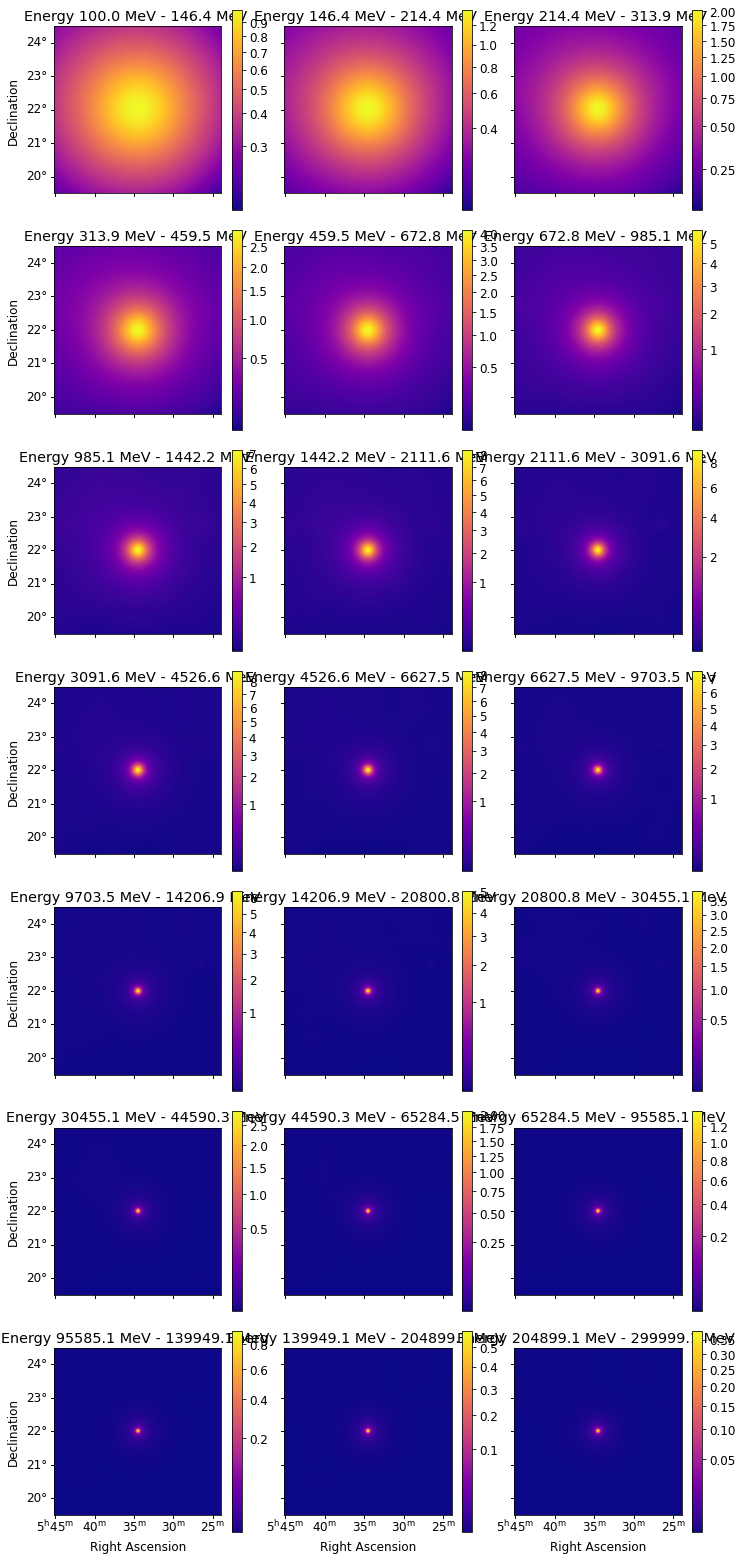

In [24]:
model_map_bins = model_map[0].plot_grid(stretch="sqrt",cmap='plasma', add_cbar=True)
plt.savefig("Crab_5_bin_6/model_bins.png")

# Count bin

In [23]:
import os

# %matplotlib inline
import numpy as np
from astropy import units as u
from astropy.convolution import convolve
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
from gammapy.data import EventList
from gammapy.maps import Map, MapAxis, WcsGeom, WcsNDMap

In [24]:
h.info()

Filename: Crab_5_bin_6/ccube_00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     137   (500, 500, 21)   int32   
  1  EBOUNDS       1 BinTableHDU     43   21R x 3C   [I, 1E, 1E]   
  2  GTI           1 BinTableHDU     50   74765R x 2C   [D, D]   


In [25]:
Ener = Table.read(h["EBOUNDS"])
Ener

<Table length=21>
CHANNEL    E_MIN       E_MAX   
            keV         keV    
 int16    float32     float32  
------- ----------- -----------
      1    100000.0   146412.17
      2   146412.17   214365.27
      3   214365.27   313856.84
      4   313856.84   459524.66
      5   459524.66   672800.06
      6   672800.06    985061.2
      7    985061.2   1442249.6
      8   1442249.6   2111629.0
      9   2111629.0   3091682.0
    ...         ...         ...
     13   9703456.0  14207041.0
     14  14207041.0  20800838.0
     15  20800838.0  30454960.0
     16  30454960.0  44589772.0
     17  44589772.0  65284856.0
     18  65284856.0  95584980.0
     19  95584980.0 139948050.0
     20 139948050.0 204901000.0
     21 204901000.0 300000000.0

In [26]:
E_MIN = list(Ener["E_MIN"])
E_MIN_MeV = (E_MIN * u.keV).to(u.MeV)
E_MIN_MeV

<Quantity [1.0000001e+02, 1.4641219e+02, 2.1436528e+02, 3.1385687e+02,
           4.5952469e+02, 6.7280011e+02, 9.8506122e+02, 1.4422496e+03,
           2.1116292e+03, 3.0916821e+03, 4.5265991e+03, 6.6274927e+03,
           9.7034561e+03, 1.4207042e+04, 2.0800840e+04, 3.0454961e+04,
           4.4589773e+04, 6.5284859e+04, 9.5584984e+04, 1.3994805e+05,
           2.0490100e+05] MeV>

In [27]:
E_MAX = list(Ener["E_MAX"])
E_MAX_MeV = (E_MAX * u.keV).to(u.MeV)
E_MAX_MeV

<Quantity [1.4641219e+02, 2.1436528e+02, 3.1385687e+02, 4.5952469e+02,
           6.7280011e+02, 9.8506122e+02, 1.4422496e+03, 2.1116292e+03,
           3.0916821e+03, 4.5265991e+03, 6.6274927e+03, 9.7034561e+03,
           1.4207042e+04, 2.0800840e+04, 3.0454961e+04, 4.4589773e+04,
           6.5284859e+04, 9.5584984e+04, 1.3994805e+05, 2.0490100e+05,
           3.0000000e+05] MeV>

### Catalog set up

In [28]:
wcs = WCS(h[0].header).dropaxis(-1)  # load the coordinate system, drop the energy axis

Set MJD-END to 59582.996227 from DATE-END'. [astropy.wcs.wcs]


In [29]:
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---AIT'  'DEC--AIT'  
CRVAL : 83.633  22.0145  
CRPIX : 250.5  250.5  
NAXIS : 500  500

In [31]:
wcs.array_shape

(500, 500)

In [32]:
Check_Center = wcs.pixel_to_world([250.5, 250.5],[250.5, 250.5]) 

In [33]:
Check_Center

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(83.62221279, 22.02449965), (83.62221279, 22.02449965)]>

In [41]:
RAJ2000 = [81.5908,83.633,83.6331,83.6367,86.1093]
DEJ2000	 = [22.7778,22.02,22.0199,22.0149,22.6418]

In [42]:
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---AIT'  'DEC--AIT'  
CRVAL : 83.633  22.0145  
CRPIX : 250.5  250.5  
NAXIS : 500  500

In [43]:
print(gta.roi['4FGL J0534.5+2201i'])

Name           : 4FGL J0534.5+2201i
Associations   : ['4FGL J0534.5+2201i', 'Crab Nebula', 'J0534+2205', 'Crab']
RA/DEC         :     83.633/    22.020
GLON/GLAT      :    184.553/    -5.781
TS             : nan
Npred          : 32705.03
Flux           :  9.72e-08 +/-      nan
EnergyFlux     : 0.0003193 +/-      nan
SpatialModel   : RadialGaussian
SpectrumType   : LogParabola
Spectral Parameters
b'norm'        :    5.5e-13 +/-        nan
b'alpha'       :       1.75 +/-        nan
b'beta'        :       0.08 +/-        nan
b'Eb'          :      1e+04 +/-        nan


In [50]:
sources

<Table length=5>
   Source_Name     RAJ2000 DEJ2000    GLON      GLAT    Conf_68_SemiMajor ... ASSOC_PROB_LR   RA_Counterpart   DEC_Counterpart   Unc_Counterpart Flags
      str18        float32 float32  float32   float32        float32      ...    float32         float64           float64           float32     int16
------------------ ------- ------- --------- ---------- ----------------- ... ------------- ----------------- ------------------ --------------- -----
4FGL J0526.3+2246  81.5908 22.7778 182.88174  -6.956808       0.029417891 ...           0.0     81.5918081625      22.8005882111         5.7e-07     0
4FGL J0534.5+2201i  83.633   22.02 184.55273  -5.781481               nan ...           nan 83.62899780273438 22.020000457763672            0.06  2048
4FGL J0534.5+2201s 83.6331 22.0199 184.55287  -5.781456               nan ...     0.9998551 83.62999725341797 22.020000457763672         0.00045    20
4FGL J0534.5+2200  83.6367 22.0149 184.55891 -5.7813134      0.0045021093 ...    0.99996907 83.62999725341797 22.020000457763672    3.681828e-05     0
4FGL J0544.4+2238  86.1093 22.6418  185.2363 -3.5079103        0.07696757 ...           0.0               nan                nan             nan     0

In [36]:
# 98.483	17.7723
coord = SkyCoord(128.837, -45.1781, unit="deg", frame='fk5')
pixels = wcs.world_to_pixel(coord)
pixels 

(array(36.96475473), array(36.91499978))

In [37]:
coord = SkyCoord(128.2872, -45.1901, unit="deg", frame='fk5')
pixels = wcs.world_to_pixel(coord)
pixels 

(array(56.33836887), array(36.24930889))

In [38]:
coord = SkyCoord(129.7229, -45.8674, unit="deg", frame='fk5')
pixels = wcs.world_to_pixel(coord)
pixels 

(array(6.12173839), array(2.2805678))

In [39]:
t = [(56.33836887,36.24930889)]

In [40]:
np.arange(len(sources))

array([0, 1, 2])

In [41]:
sources['RAJ2000'][1]

128.837

In [51]:
t=[]
for i in range(len(sources)):
    coord = SkyCoord(sources['RAJ2000'][i], sources['DEJ2000'][i], unit="deg", frame='fk5')
    a = np.array([wcs.world_to_pixel(coord)[0],float(wcs.world_to_pixel(coord)[1])])
    t.append(a)
#t=[]
#for i in range(len(sources)):
#    coord = SkyCoord(RAJ2000[i], DEJ2000[i], unit="deg", frame='fk5')
#    a  = float(wcs.world_to_pixel(coord)[0]),float(wcs.world_to_pixel(coord)[1])
#    t.append(a)

In [52]:
t

[array([437.79000474, 327.08981889]),
 array([249.49970011, 250.05004578]),
 array([249.49050539, 250.03993683]),
 array([249.15665437, 249.54002491]),
 array([ 20.96576243, 314.08395642])]

In [53]:
t[0]

array([437.79000474, 327.08981889])

In [54]:
t[0][0]

437.79000473867563

In [46]:
t

[array([56.33833562, 36.24922794]),
 array([36.96455682, 36.91497048]),
 array([6.12172541, 2.28051151])]

In [47]:
SkyCoord(sources['RAJ2000'][i], sources['DEJ2000'][i], unit="deg", frame='fk5')

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (129.72290039, -45.86740112)>

### plot

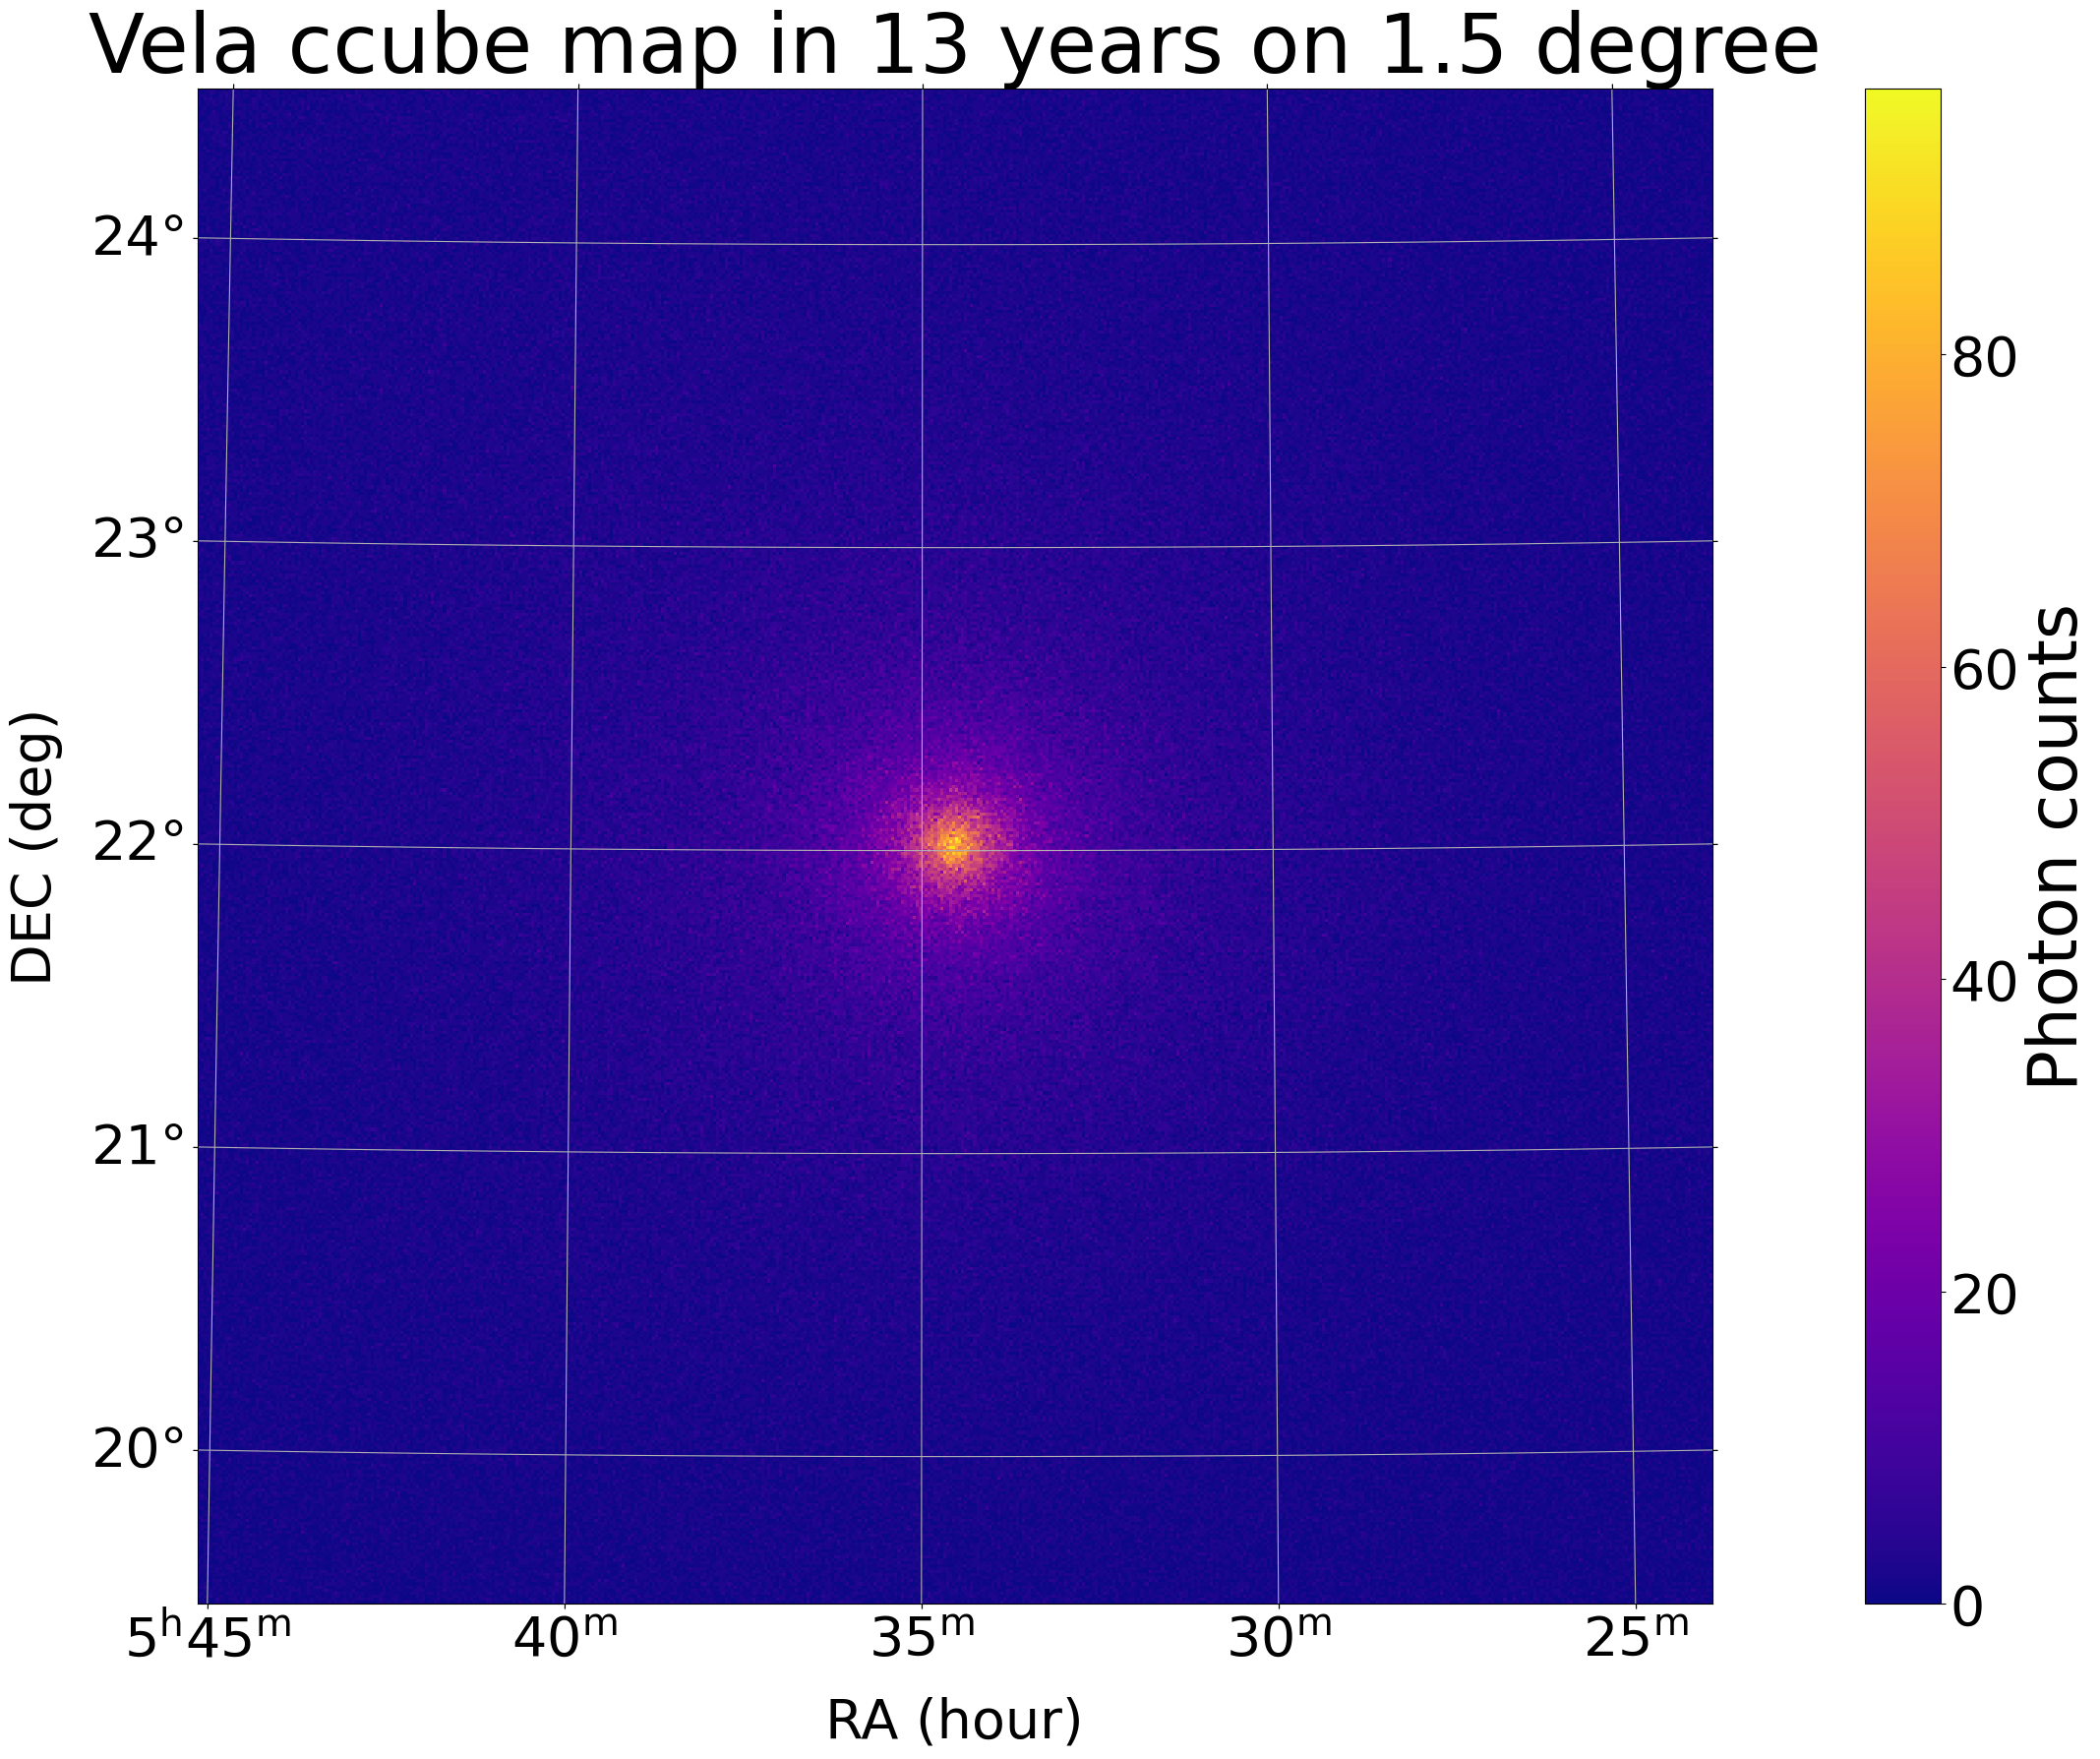

In [55]:
plt.subplots(figsize=(40,20))

counts = h[0].data

plt.subplot(projection=wcs)
im = plt.imshow(np.sum(counts,axis=0),interpolation='nearest',origin='lower', cmap='plasma')

#ax.set_xlim(304.47318, 281.0085)
#ax.set_ylim(0.3-1.5, 0.3+1.5)

plt.tick_params(axis="x", labelsize=40)
plt.tick_params(axis="y", labelsize=40)
#cbar = fig.colorbar(count,ax=ax,ticks=np.arange(0,200,10))

#plt.title("Geminga ccube map",fontsize = 60)

plt.grid()
plt.gca().tick_params(direction='out')
plt.gca().set_xlabel("RA (hour)",fontsize=40)
plt.gca().set_ylabel("DEC (deg)",fontsize=40)
cbar = plt.colorbar(im, label="counts")
im.figure.axes[1].tick_params(labelsize=40) 
cbar.set_label("Photon counts",fontsize=50) 
plt.title("Vela ccube map in 13 years on 1.5 degree",fontsize = 60)
#plt.savefig("Geminga_1.5_bin6/Geminga ccube map in 13 years on 1.5 degree.png")
plt.show()
#plt.savefig("Crab_5_bin_6/ccube_00.png")

In [56]:
pixels

NameError: name 'pixels' is not defined

In [57]:
sources['Source_Name']

<Column name='Source_Name' dtype='str18' length=5>
4FGL J0526.3+2246 
4FGL J0534.5+2201i
4FGL J0534.5+2201s
4FGL J0534.5+2200 
4FGL J0544.4+2238

In [58]:
t

[array([437.79000474, 327.08981889]),
 array([249.49970011, 250.05004578]),
 array([249.49050539, 250.03993683]),
 array([249.15665437, 249.54002491]),
 array([ 20.96576243, 314.08395642])]

In [59]:
t

[array([437.79000474, 327.08981889]),
 array([249.49970011, 250.05004578]),
 array([249.49050539, 250.03993683]),
 array([249.15665437, 249.54002491]),
 array([ 20.96576243, 314.08395642])]

In [60]:
t[0][0]

437.79000473867563

IndexError: list index out of range

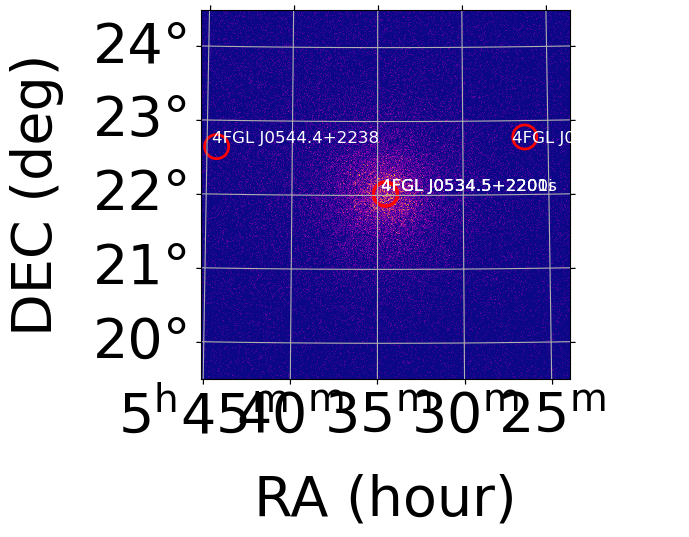

In [66]:
fig = plt.figure(figsize=(40,20))
ax = plt.subplot(projection=wcs)

im = ax.imshow(np.sum(counts,axis=0),interpolation='nearest',origin='lower', cmap='plasma')
 
#for i, txt in enumerate(sources['Source_Name']):           
#    ax.annotate(txt,( t[i][0]-3, t[i][1]+3 ),fontsize=30,color='w')
#    ax.scatter(t[i][0] ,t[i][1],edgecolor = 'red' , s=3000 ,linewidths=5, facecolor='none')
plt.subplot(projection=wcs)
im = plt.imshow(counts[i],interpolation='nearest',origin='lower', cmap='plasma')

#4FGL J0833.1-4511e
plt.annotate("4FGL J0526.3+2246",( 437.79000474-17, 327.08981889-7 ),fontsize=12,color='w')
plt.scatter(437.79000474, 327.08981889 ,edgecolor = 'red' , s=300 ,linewidths=2, facecolor='none')

#4FGL J0835.3-4510
plt.annotate("4FGL J0534.5+2201i",( 249.49970011-6,250.05004578+5 ),fontsize=12,color='w')
plt.scatter(249.49970011, 250.05004578 ,edgecolor = 'red' , s=300 ,linewidths=2, facecolor='none')

#4FGL J0838.8-4552
plt.annotate("4FGL J0534.5+2201s",( 249.49050539-6,250.03993683+5 ),fontsize=12,color='w')
plt.scatter(249.49050539, 250.03993683,edgecolor = 'red' , s=300 ,linewidths=2, facecolor='none')


plt.annotate("4FGL J0534.5+2200",( 249.15665437-6, 249.54002491+5 ),fontsize=12,color='w')
plt.scatter(249.15665437, 249.54002491,edgecolor = 'red' , s=300 ,linewidths=2, facecolor='none')


plt.annotate("4FGL J0544.4+2238",( 20.96576243-6, 314.08395642+5 ),fontsize=12,color='w')
plt.scatter(20.96576243, 314.08395642,edgecolor = 'red' , s=300 ,linewidths=2, facecolor='none')

ax.tick_params(axis="x", labelsize=40)
ax.tick_params(axis="y", labelsize=40)
ax.grid()
#ax.gca().tick_params
#ax.gca().tick_params(direction='out')
ax.set_xlabel("RA (hour)",fontsize=40)
ax.set_ylabel("DEC (deg)",fontsize=40)
#ax.gca().set_xlabel("R.A. (deg)",fontsize=40)
#plt.gca().set_ylabel("Dec. (deg)",fontsize=40)
cbar = fig.colorbar(im, label="counts")
im.figure.axes[1].tick_params(labelsize=40) 
cbar.set_label("Photon counts",fontsize=50) 

plt.title("Vela ccube map in 13 years on 1.5 degree",fontsize = 60)
plt.show()
#plt.savefig("Vela_1.5_bin6/Geminga ccube map in 13 years on 1.5 degree.png")

# Slide energy map

### Side of maps

In [62]:
E_MIN_MeV

<Quantity [1.0000001e+02, 1.4641219e+02, 2.1436528e+02, 3.1385687e+02,
           4.5952469e+02, 6.7280011e+02, 9.8506122e+02, 1.4422496e+03,
           2.1116292e+03, 3.0916821e+03, 4.5265991e+03, 6.6274927e+03,
           9.7034561e+03, 1.4207042e+04, 2.0800840e+04, 3.0454961e+04,
           4.4589773e+04, 6.5284859e+04, 9.5584984e+04, 1.3994805e+05,
           2.0490100e+05] MeV>

In [63]:
E_MAX_MeV

<Quantity [1.4641219e+02, 2.1436528e+02, 3.1385687e+02, 4.5952469e+02,
           6.7280011e+02, 9.8506122e+02, 1.4422496e+03, 2.1116292e+03,
           3.0916821e+03, 4.5265991e+03, 6.6274927e+03, 9.7034561e+03,
           1.4207042e+04, 2.0800840e+04, 3.0454961e+04, 4.4589773e+04,
           6.5284859e+04, 9.5584984e+04, 1.3994805e+05, 2.0490100e+05,
           3.0000000e+05] MeV>

In [64]:
sources['Source_Name']

<Column name='Source_Name' dtype='str18' length=5>
4FGL J0526.3+2246 
4FGL J0534.5+2201i
4FGL J0534.5+2201s
4FGL J0534.5+2200 
4FGL J0544.4+2238

In [65]:
t

[array([437.79000474, 327.08981889]),
 array([249.49970011, 250.05004578]),
 array([249.49050539, 250.03993683]),
 array([249.15665437, 249.54002491]),
 array([ 20.96576243, 314.08395642])]

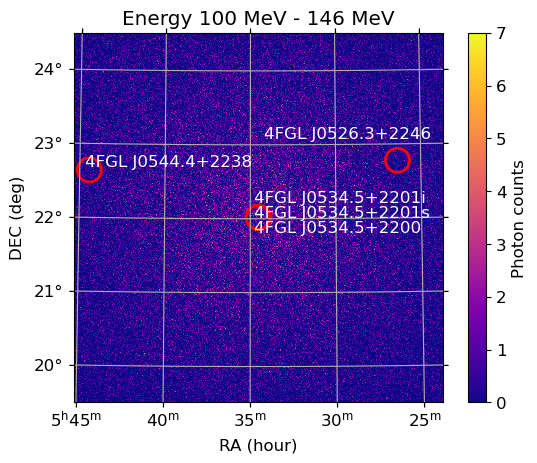

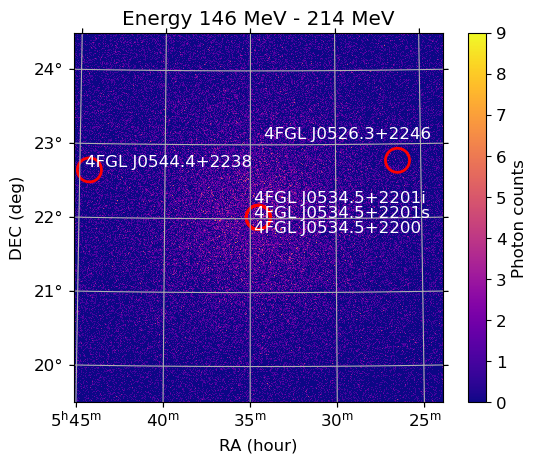

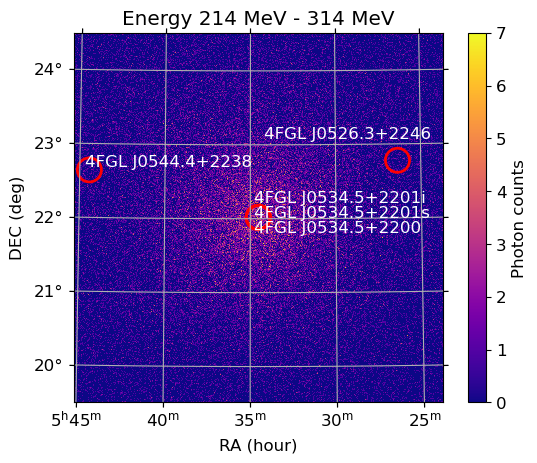

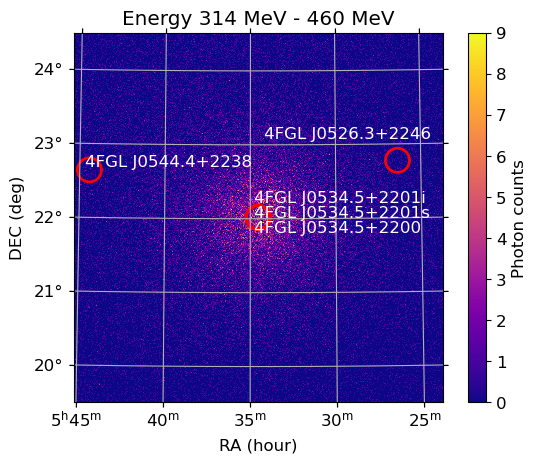

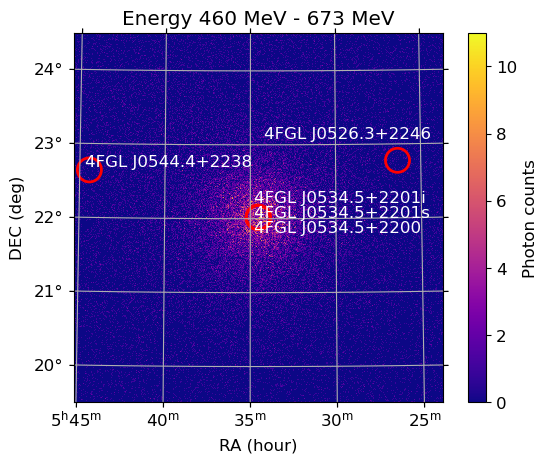

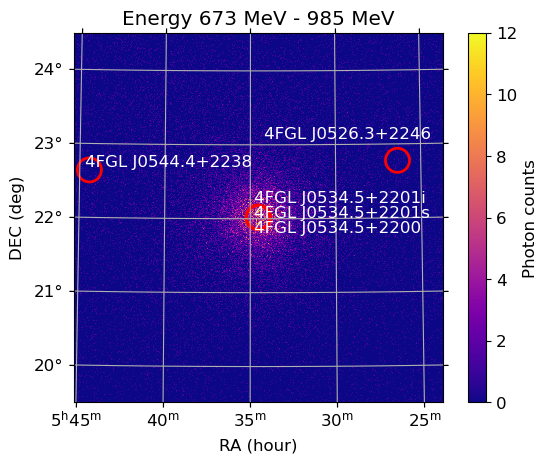

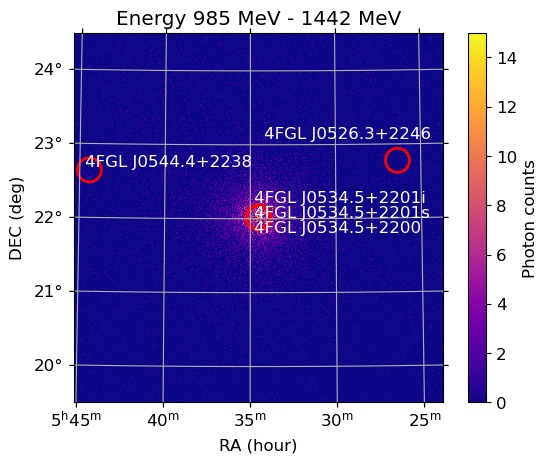

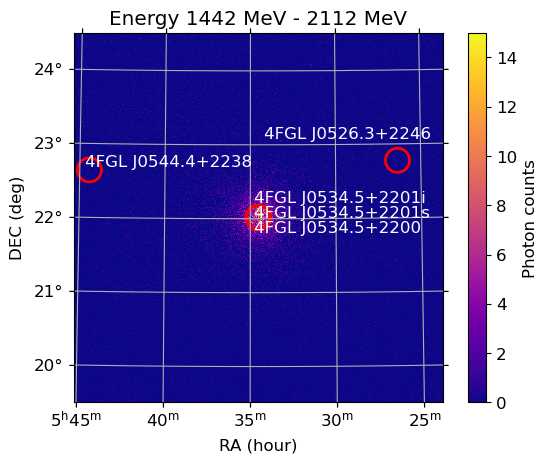

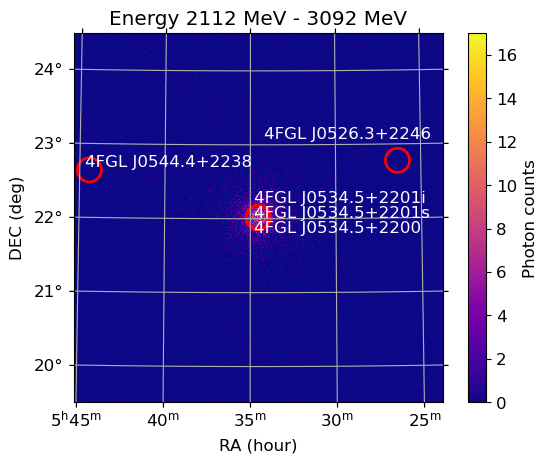

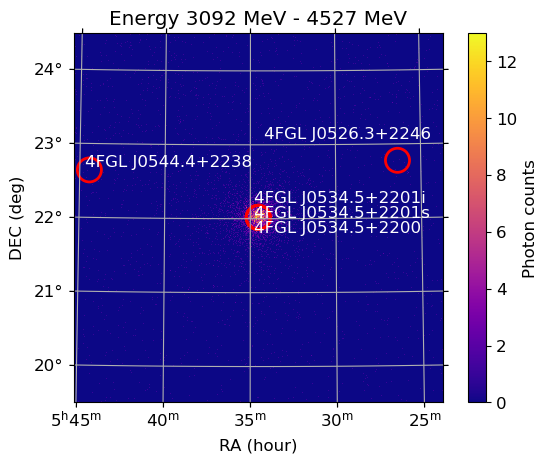

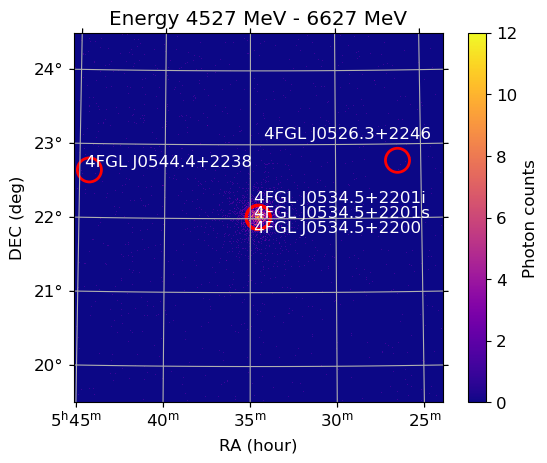

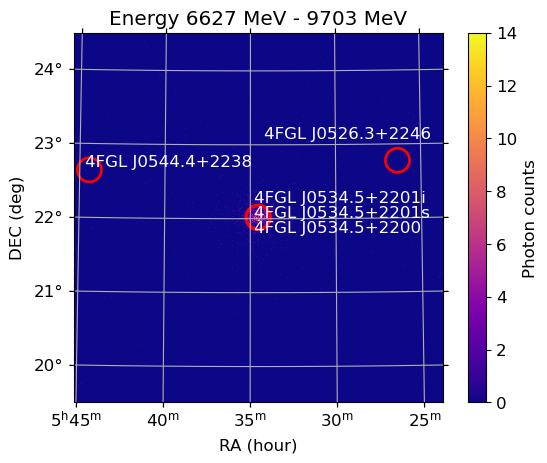

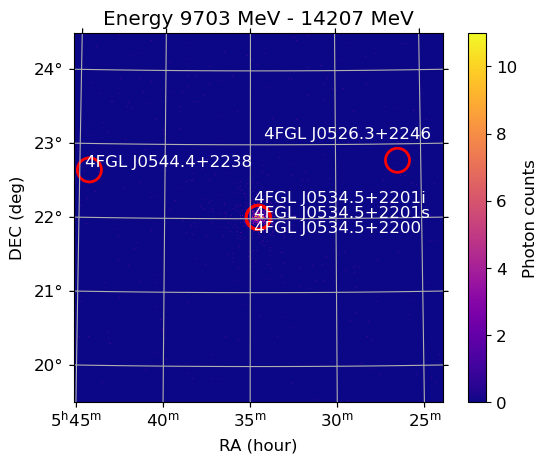

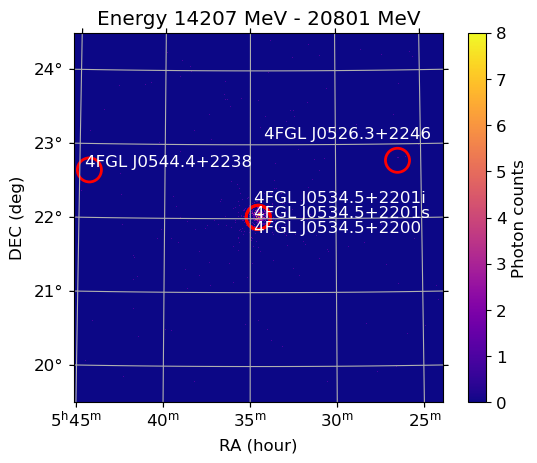

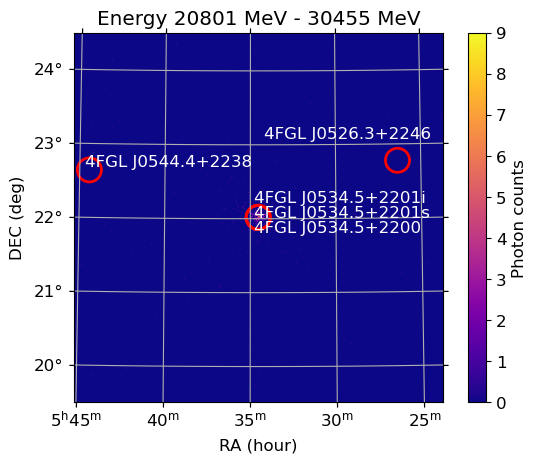

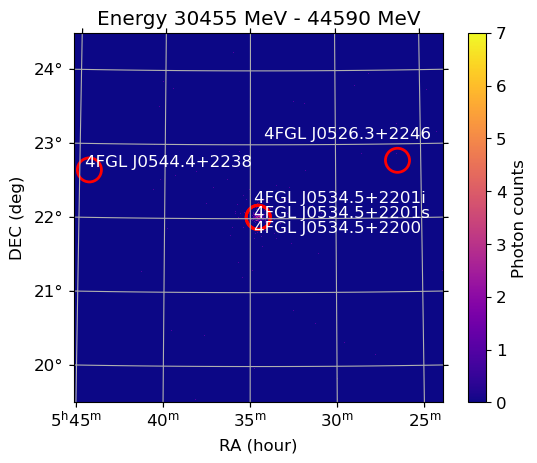

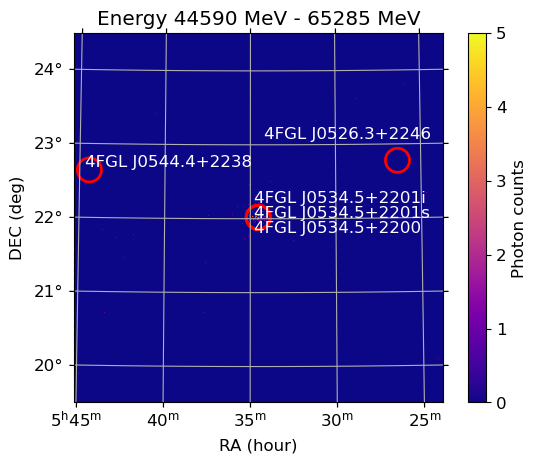

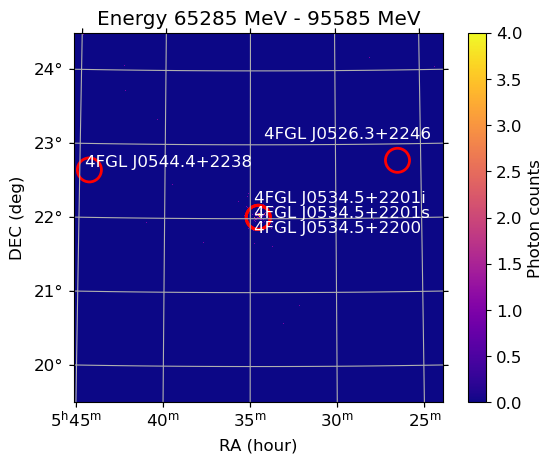

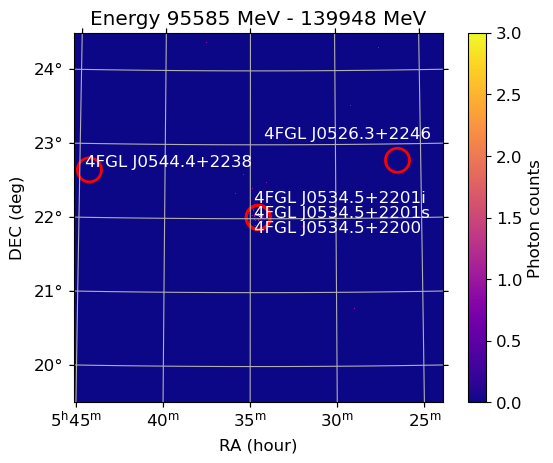

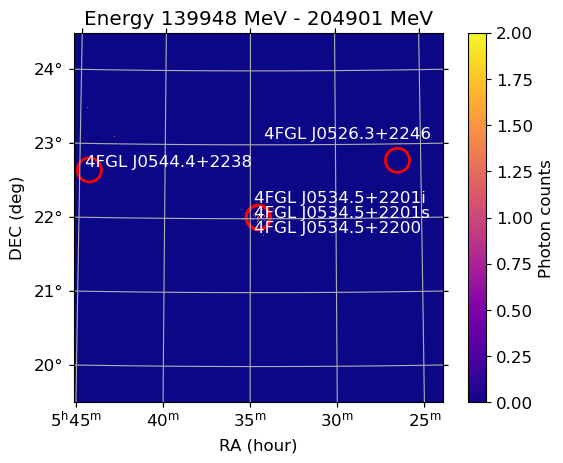

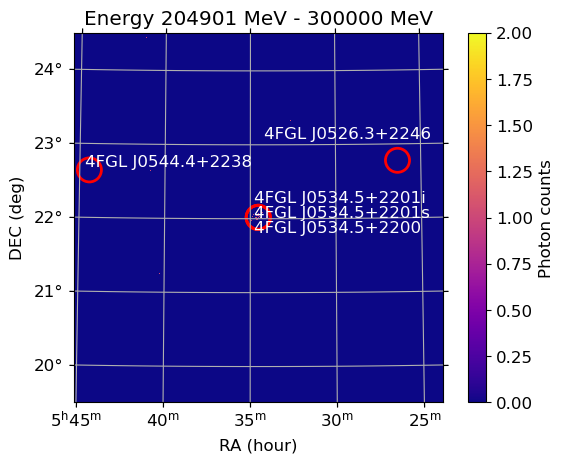

In [74]:
for i in range(len(E_MAX_MeV)):
    
    counts = h[0].data

    plt.subplot(projection=wcs)
    im = plt.imshow(counts[i],interpolation='nearest',origin='lower', cmap='plasma')
    
    #4FGL J0833.1-4511e
    plt.annotate("4FGL J0526.3+2246",( 437.79000474-180, 327.08981889+30 ),fontsize=12,color='w')
    plt.scatter(437.79000474, 327.08981889 ,edgecolor = 'red' , s=300 ,linewidths=2, facecolor='none')
    
    #4FGL J0835.3-4510
    plt.annotate("4FGL J0534.5+2201i",( 249.49970011-6,250.05004578+20 ),fontsize=12,color='w')
    plt.scatter(249.49970011, 250.05004578 ,edgecolor = 'red' , s=300 ,linewidths=2, facecolor='none')
    
    #4FGL J0838.8-4552
    plt.annotate("4FGL J0534.5+2201s",( 249.49050539-6,250.03993683+0 ),fontsize=12,color='w')
    plt.scatter(249.49050539, 250.03993683,edgecolor = 'red' , s=300 ,linewidths=2, facecolor='none')

    
    plt.annotate("4FGL J0534.5+2200",( 249.15665437-6, 249.54002491-20 ),fontsize=12,color='w')
    plt.scatter(249.15665437, 249.54002491,edgecolor = 'red' , s=300 ,linewidths=2, facecolor='none')

    
    plt.annotate("4FGL J0544.4+2238",( 20.96576243-6, 314.08395642+5 ),fontsize=12,color='w')
    plt.scatter(20.96576243, 314.08395642,edgecolor = 'red' , s=300 ,linewidths=2, facecolor='none')

    
    
    
    #for j, txt in enumerate(sources['Source_Name']):           
    #    plt.annotate(txt,( t[j][0]-6, t[j][1]+5 ),fontsize=12,color='w')
    #    plt.scatter(t[j][0] ,t[j][1],edgecolor = 'red' , s=300 ,linewidths=2, facecolor='none')

    #ax.set_xlim(304.47318, 281.0085)
    #ax.set_ylim(0.3-1.5, 0.3+1.5)

    plt.tick_params(axis="x")
    plt.tick_params(axis="y")
    #cbar = fig.colorbar(count,ax=ax,ticks=np.arange(0,200,10))

    #plt.title("Geminga ccube map",fontsize = 60)

    plt.grid()
    plt.gca().tick_params(direction='out')
    plt.gca().set_xlabel("RA (hour)")
    plt.gca().set_ylabel("DEC (deg)")
    cbar = plt.colorbar(im, label="counts")

    cbar.set_label("Photon counts") 
    plt.title("Energy %.0f MeV - %.0f MeV" %(E_MIN_MeV[i].value,E_MAX_MeV[i].value))
    plt.savefig("__Energy %.0f MeV - %.0f MeV.png"  %(E_MIN_MeV[i].value,E_MAX_MeV[i].value))
    plt.show()
    #plt.savefig("Crab_5_bin_6/ccube_00.png")




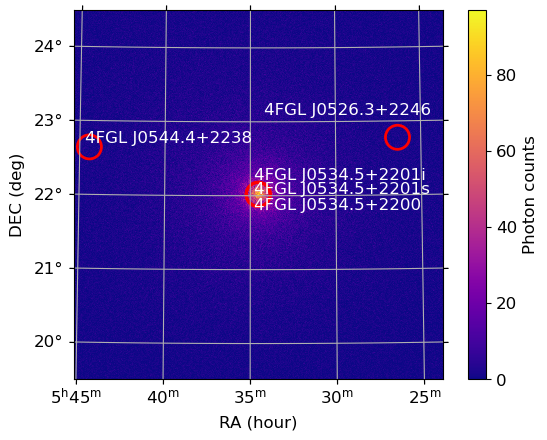

In [93]:

counts = h[0].data

plt.subplot(projection=wcs)
im = plt.imshow(np.sum(counts,axis=0),interpolation='nearest',origin='lower', cmap='plasma')

#4FGL J0833.1-4511e
plt.annotate("4FGL J0526.3+2246",( 437.79000474-180, 327.08981889+30 ),fontsize=12,color='w')
plt.scatter(437.79000474, 327.08981889 ,edgecolor = 'red' , s=300 ,linewidths=2, facecolor='none')

#4FGL J0835.3-4510
plt.annotate("4FGL J0534.5+2201i",( 249.49970011-6,250.05004578+20 ),fontsize=12,color='w')
plt.scatter(249.49970011, 250.05004578 ,edgecolor = 'red' , s=300 ,linewidths=2, facecolor='none')

#4FGL J0838.8-4552
plt.annotate("4FGL J0534.5+2201s",( 249.49050539-6,250.03993683+0 ),fontsize=12,color='w')
plt.scatter(249.49050539, 250.03993683,edgecolor = 'red' , s=300 ,linewidths=2, facecolor='none')


plt.annotate("4FGL J0534.5+2200",( 249.15665437-6, 249.54002491-20 ),fontsize=12,color='w')
plt.scatter(249.15665437, 249.54002491,edgecolor = 'red' , s=300 ,linewidths=2, facecolor='none')


plt.annotate("4FGL J0544.4+2238",( 20.96576243-6, 314.08395642+5 ),fontsize=12,color='w')
plt.scatter(20.96576243, 314.08395642,edgecolor = 'red' , s=300 ,linewidths=2, facecolor='none')




#for j, txt in enumerate(sources['Source_Name']):           
#    plt.annotate(txt,( t[j][0]-6, t[j][1]+5 ),fontsize=12,color='w')
#    plt.scatter(t[j][0] ,t[j][1],edgecolor = 'red' , s=300 ,linewidths=2, facecolor='none')

#ax.set_xlim(304.47318, 281.0085)
#ax.set_ylim(0.3-1.5, 0.3+1.5)

plt.tick_params(axis="x")
plt.tick_params(axis="y")
#cbar = fig.colorbar(count,ax=ax,ticks=np.arange(0,200,10))

#plt.title("Geminga ccube map",fontsize = 60)

plt.grid()
plt.gca().tick_params(direction='out')
plt.gca().set_xlabel("RA (hour)")
plt.gca().set_ylabel("DEC (deg)")
cbar = plt.colorbar(im, label="counts")

cbar.set_label("Photon counts") 
#plt.title("Energy %.0f MeV - %.0f MeV" %(E_MIN_MeV[i].value,E_MAX_MeV[i].value))
#plt.savefig("__Energy %.0f MeV - %.0f MeV.png"  %(E_MIN_MeV[i].value,E_MAX_MeV[i].value))
plt.show()
#plt.savefig("Crab_5_bin_6/ccube_00.png")




### Reading in the results

The results are saved and you can retrieve them from the output numpy file. 

In [25]:
c = np.load('Crab_5_bin_6/fit0.npy', allow_pickle=True).flat[0]

The `sources` dictionary has an entry for each source in the model:

In [26]:
sorted(c['sources'].keys())

['4FGL J0526.3+2246',
 '4FGL J0534.5+2200',
 '4FGL J0534.5+2201i',
 '4FGL J0534.5+2201s',
 '4FGL J0544.4+2238',
 'galdiff',
 'isodiff']

Let's take a look at the flux, spectral parameters, and TS of one of the sources.

In [27]:
c['sources']['4FGL J0534.5+2201i']['flux']

6.932485637823697e-07

In [28]:
print(c['sources']['4FGL J0534.5+2201i']['param_names'][:4])
print(c['sources']['4FGL J0534.5+2201i']['param_values'][:4])

[b'norm' b'alpha' b'beta' b'Eb']
[7.69418641e-13 2.04079306e+00 1.81201761e-02 1.00000000e+04]


In [29]:
c['sources']['4FGL J0534.5+2201i']['ts']

25021.474880365655

You can also plot the spectral energy distribution (SED) for this source :

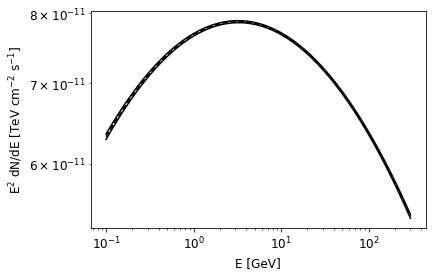

In [30]:
E = np.array(c['sources']['4FGL J0534.5+2201i']['model_flux']['energies'])
dnde = np.array(c['sources']['4FGL J0534.5+2201i']['model_flux']['dnde'])
dnde_hi = np.array(c['sources']['4FGL J0534.5+2201i']['model_flux']['dnde_hi'])
dnde_lo = np.array(c['sources']['4FGL J0534.5+2201i']['model_flux']['dnde_lo'])

plt.loglog(E/1e3, (E**2)*dnde*1e-6, 'k--')
plt.loglog(E/1e3, (E**2)*dnde_hi*1e-6, 'k')
plt.loglog(E/1e3, (E**2)*dnde_lo*1e-6, 'k')
plt.xlabel('E [GeV]')
plt.ylabel(r'E$^2$ dN/dE [TeV cm$^{-2}$ s$^{-1}$]')
plt.show()
#plt.savefig("crab_2019/spectrum.png")

To plot the SED points, there's a function for that :

In [31]:
sed = gta.sed('4FGL J0534.5+2201i')

2022-03-03 13:55:46 INFO    GTAnalysis.sed(): Computing SED for 4FGL J0534.5+2201i
2022-03-03 13:55:55 INFO    GTAnalysis._make_sed(): Fitting SED
2022-03-03 13:55:55 INFO    GTAnalysis.free_source(): Fixing parameters for 4FGL J0534.5+2200     : ['Index1', 'Expfactor']
2022-03-03 13:55:55 INFO    GTAnalysis.free_source(): Fixing parameters for 4FGL J0534.5+2201s    : ['Index']
2022-03-03 13:55:55 INFO    GTAnalysis.free_source(): Fixing parameters for 4FGL J0534.5+2201i    : ['alpha', 'beta']
2022-03-03 13:55:55 INFO    GTAnalysis.free_source(): Fixing parameters for 4FGL J0526.3+2246     : ['Index']
2022-03-03 13:55:55 INFO    GTAnalysis.free_source(): Fixing parameters for 4FGL J0544.4+2238     : ['Index']
/home/user/miniconda3/envs/fermi/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:279: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation

In [32]:
src = gta.roi['4FGL J0534.5+2201i']

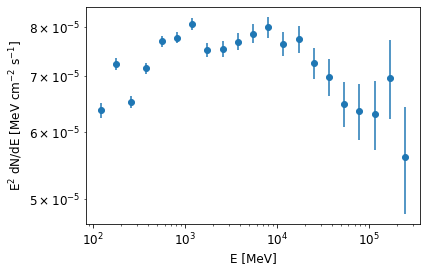

In [33]:
plt.loglog()
plt.errorbar(np.array(sed['e_ctr']),
             sed['e2dnde'], 
             yerr=sed['e2dnde_err'], fmt ='o')
plt.xlabel('E [MeV]')
plt.ylabel(r'E$^{2}$ dN/dE [MeV cm$^{-2}$ s$^{-1}$]')
plt.show()

THe error bars for highest energy points are very large, it looks like those last three points should be upper limits. Let's plot those instead.

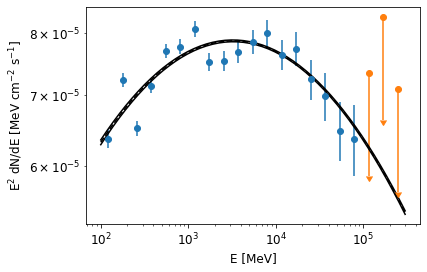

In [34]:
plt.loglog(E, (E**2)*dnde, 'k--')
plt.loglog(E, (E**2)*dnde_hi, 'k')
plt.loglog(E, (E**2)*dnde_lo, 'k')
plt.errorbar(sed['e_ctr'][:-3],
             sed['e2dnde'][:-3], 
             yerr=sed['e2dnde_err'][:-3], fmt ='o')
plt.errorbar(np.array(sed['e_ctr'][-3:]),
         sed['e2dnde_ul95'][-3:], yerr=0.2*sed['e2dnde_ul95'][-3:], 
             fmt='o', uplims=True)
plt.xlabel('E [MeV]')
plt.ylabel(r'E$^{2}$ dN/dE [MeV cm$^{-2}$ s$^{-1}$]')
plt.show()

Let's change unit (MeV -> GeV for the x axis and MeV -> TeV for the y axis)

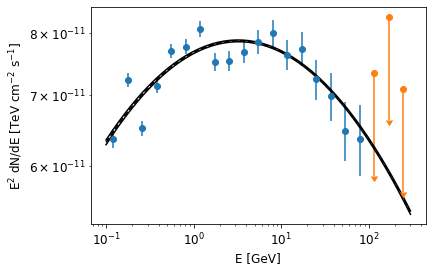

In [35]:
plt.loglog(E*1e-3, (E**2)*dnde*1e-6, 'k--')
plt.loglog(E*1e-3, (E**2)*dnde_hi*1e-6, 'k')
plt.loglog(E*1e-3, (E**2)*dnde_lo*1e-6, 'k')
plt.errorbar(sed['e_ctr'][:-3]*1e-3,
             sed['e2dnde'][:-3]*1e-6, 
             yerr=sed['e2dnde_err'][:-3]*1e-6, fmt ='o')
plt.errorbar(np.array(sed['e_ctr'][-3:]*1e-3),
         sed['e2dnde_ul95'][-3:]*1e-6, yerr=0.2*sed['e2dnde_ul95'][-3:]*1e-6, 
             fmt='o', uplims=True)

plt.xlabel('E [GeV]')
plt.ylabel(r'E$^{2}$ dN/dE [TeV cm$^{-2}$ s$^{-1}$]')
plt.show()